# Recommendation systems course - Final Project
## Deep Neural Networks for YouTune Recommendations

**By:**  

Group #4

Oren Avidan

Maytar Shalit

<br><br>

# Introduction



## Intro
YouTube was found on February 14, 2005, and on November 13, 2006 was bought by Google. Since then, YouTube has become one of the largest video platforms on the Interent. In order to keep users on the platofrm for as long as possible, YouTube has developed one of the most advanced recommendation systems in the industry. The difference between YouTube and other content platforms such as Netflix and Spotify, is that the platform's corpus is being updated with thousands of hours of videos every second. YouTube’s corpus is constantly expanding and changing, and it's hard to keep on track of the content being uploaded. Thus, YouTube created a robust model that handles constant incoming data and outputing quality recommendations in real time.

In this project we will implement YouTube's recommendation systems as described in [this paper](https://storage.googleapis.com/pub-tools-public-publication-data/pdf/45530.pdf). We will examine the results and compare them with 2 other models - one improved model we have created, and one "classic model", to see which of them works the better. 


## Article Summary 
YouTube's recommendation system has two stages comprised of two neural networks - candidate generation NN and a ranking NN.

1.	**The Candidate generation network** takes YouTube’s entire video corpus (millions of videos) and shrinks it to a limited number of videos, using the user’s number of videos watched, watch history, user search query, and other demographic information. This stage is using user-based collaborative filtering – comparing users and recommending items to a user based on the preferences and behaviors of similar users.
2.	**The ranking network** takes the output of the Candidate generation network and uses features from both the video and the user to minimize the recommendation to a few videos. Data used here is user language, video language, and previous impressions. The output of this stage is ranking them according to the probability of each of them to be the next video watched by the user. Of those, the system will choose the top n. 

For this project, we used the ML dataset in the size 100k due to computing-power limitations. The dataset contains 100K ratings of 1682 different movies, given by 943 different users. In order to use the data in the model, we had to do pre-processing and change the shape and format to the correct one. As suggested in class, we combined the two networks into one due to the size of our dataset which includes only 100K samples instead of a corpus of millions of videos. 

As mentioned in the article, the model treats recommendation as a complex multi-class classification task, where the objective is to correctly identify a specific video watched by a user at a given time, among a large corpus of millions of videos. This classification is based on the user and the context in which the video was watched.


## Imports

In [1]:
# basic
import os 
import sys
import math
import heapq
import argparse
from time import time
import multiprocessing

# general / ml
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import scipy.sparse as sp

# zip file
from timeit import default_timer as timer
import random
import zipfile
import requests
import warnings
import ast

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from wordcloud import WordCloud, STOPWORDS

# visual 3D
from mpl_toolkits import mplot3d

# notebook
from IPython.display import display, HTML, FileLink


# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam,SGD,RMSprop,Adamax
from tensorflow.keras.models import Sequential,Model,load_model,save_model
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding,Input,Dense,Reshape,Flatten,Dropout,Multiply,Concatenate, Dot,Lambda,Activation
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.callbacks import History as keras_history
from tensorflow.keras.callbacks import EarlyStopping
from keras import regularizers
from keras.api._v2.keras import activations




from tqdm.notebook import tqdm


import sklearn
from sklearn.metrics import mean_squared_error,ndcg_score 

# distance
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

import datetime

from sklearn.preprocessing import LabelEncoder


import pickle



**Hide Warnings**

In [2]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

**Set random seed**

In [4]:
np.random.seed(1000)

**Select relevant dataset**

In [5]:
# pick 1 of the 2:

dataset = 'ML-100k'
# dataset = 'ML-1M'

In [6]:
dataset_name,data_dir,users_delim,item_delim,rating_delim,folds_delim,u_file,i_file,r_file= 'ml-100k','datasets/ml-100k/' , '|','|','\t','\t','u.user','u.item','u.data'


In [7]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

In [8]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

# Data Importation, Exploration, and Pre-processing

### Reading and analysing raw data


Firstly, we will load the data, analyse it and make some manipulations so it would fit the model in the article. 

#### Users df

##### loading data

In [9]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users

,user_id,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
...,...,...,...,...,...
938,939,26,F,student,33319
939,940,32,M,administrator,02215
940,941,20,M,student,97229
941,942,48,F,librarian,78209


In [10]:
df_users.shape

(943, 5)

##### Data Exploration and analysis

**Users' age distribution**

[Text(0.5, 1.0, 'Users age distribution')]

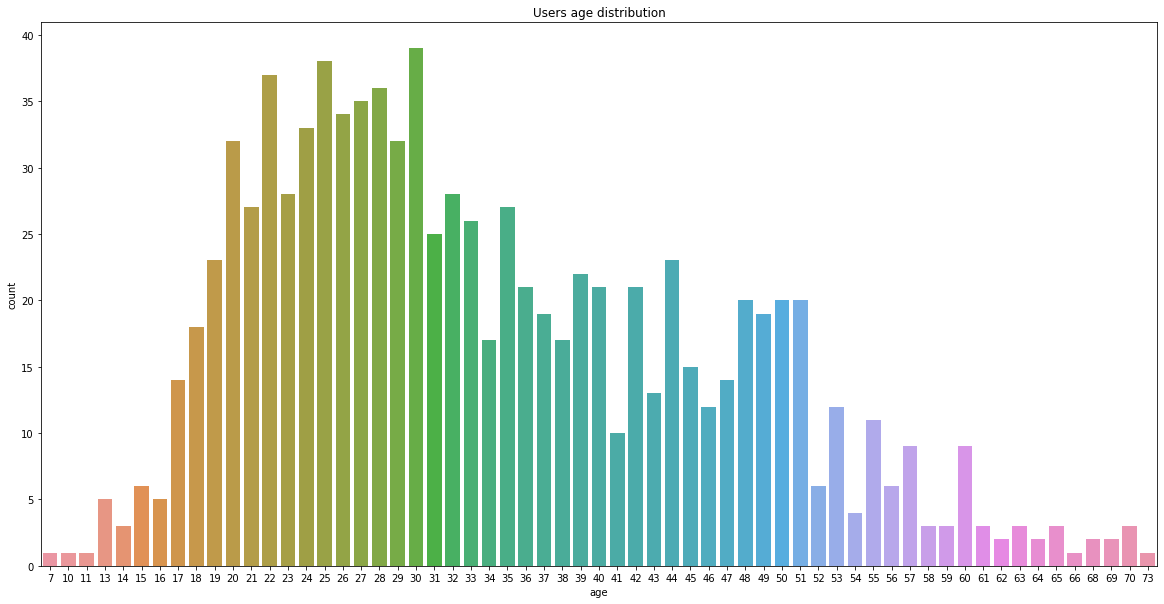

In [11]:
f, axes = plt.subplots(1, 1,figsize=(20, 10))
sns.countplot(data = df_users, x = "age").set(title='Users age distribution')

We can see that most users are in the ages of 20-50, and more specifically between 20 to 35.

**Number of users by gender**

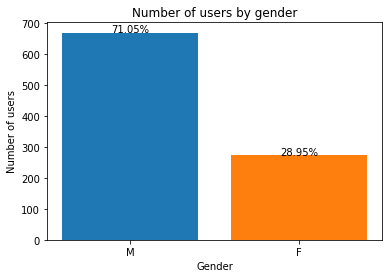

In [12]:
user_counts = df_users.groupby('gender')['user_id'].count()
user_counts = user_counts.sort_values(ascending=True)

total_users = len(df_users)
user_percents = (user_counts / total_users) * 100

colors = ['#ff7f0e', '#1f77b4']
plt.bar(user_counts.index, user_counts, color=colors)
plt.gca().invert_xaxis()


plt.title('Number of users by gender')
plt.xlabel('Gender')
plt.ylabel('Number of users')

# add a label showing the percentage of all users for each gender
for i, v in enumerate(user_counts):
    plt.text(i, v + 0.5, f'{user_percents[i]:.2f}%', ha='center')

plt.show()

We can see that 71% of users are male.

**Age distribution by gneder**

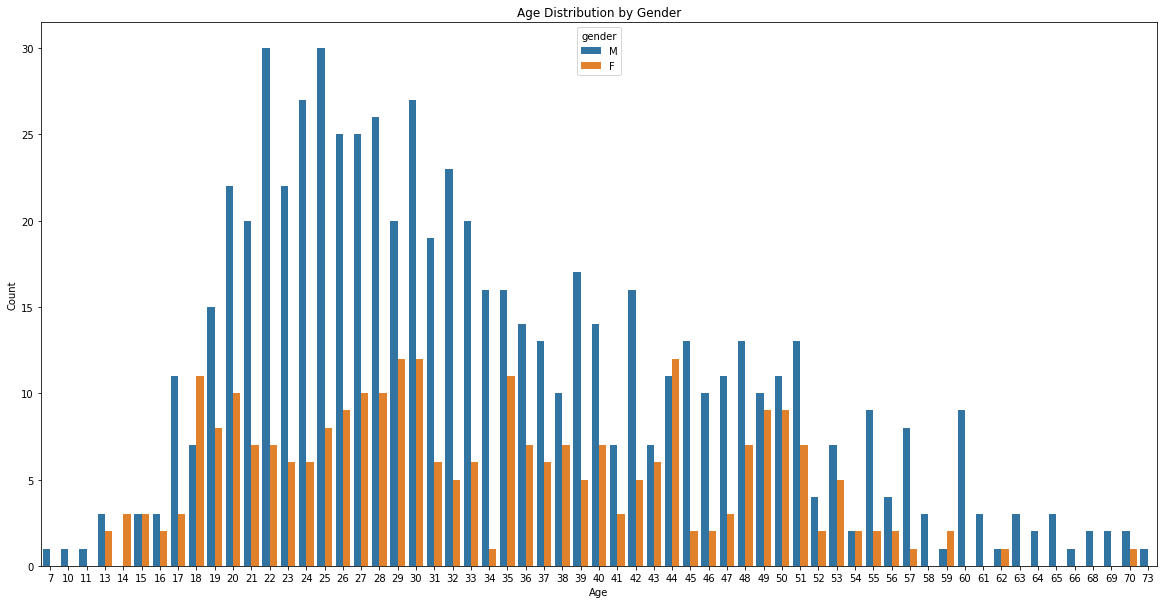

In [13]:
plt.figure(figsize=(20, 10))
sns.countplot(x='age', data=df_users, hue='gender')

plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution by Gender')

plt.show()

We can see that the Female distribution is more spread and distributed, while the majority of Men are between the ages 17 to 40. 

**User distribution by occupation**

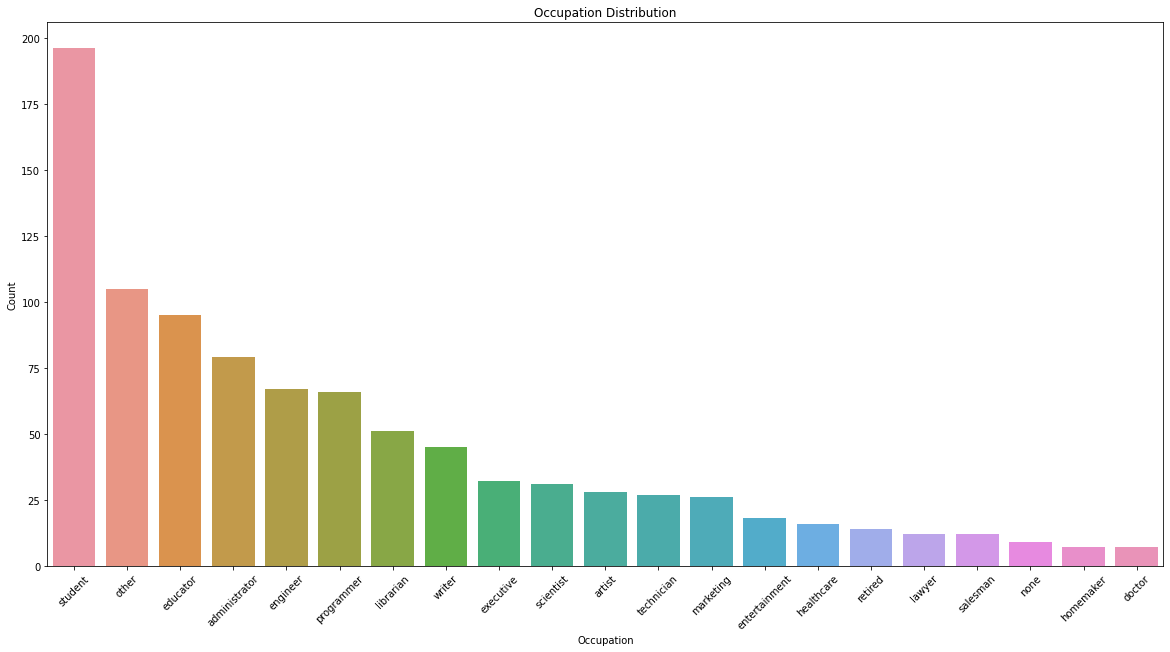

In [14]:
df_occupation = df_users.groupby(['occupation']).size().reset_index(name='counts')
df_occupation = df_occupation.sort_values(by='counts', ascending=False)

plt.figure(figsize=(20, 10))
sns.barplot(x='occupation', y='counts', data=df_occupation)

plt.xlabel('Occupation')
plt.ylabel('Count')
plt.title('Occupation Distribution')

plt.xticks(rotation=45)

plt.show()

##### Data pre-processing

In [15]:
# Normalize the age of each user between 0 and 1
age_min = df_users['age'].min()
age_max = df_users['age'].max()
df_users['age_normalized'] = (df_users['age'] - age_min) / (age_max - age_min)

# Add columns for squared and rooted
df_users['age_normalized_squared'] = df_users['age_normalized'] ** 2
df_users['age_normalized_sqrt'] = np.sqrt(df_users['age_normalized'])

df_users

,user_id,age,gender,occupation,zip code,age_normalized,age_normalized_squared,age_normalized_sqrt
0,1,24,M,technician,85711,0.257576,0.066345,0.507519
1,2,53,F,other,94043,0.696970,0.485767,0.834847
2,3,23,M,writer,32067,0.242424,0.058770,0.492366
3,4,24,M,technician,43537,0.257576,0.066345,0.507519
4,5,33,F,other,15213,0.393939,0.155188,0.627646
...,...,...,...,...,...,...,...,...
938,939,26,F,student,33319,0.287879,0.082874,0.536543
939,940,32,M,administrator,02215,0.378788,0.143480,0.615457
940,941,20,M,student,97229,0.196970,0.038797,0.443813
941,942,48,F,librarian,78209,0.621212,0.385904,0.788170


We will encode the gender and occupation so the could be fed into the model - 

In [16]:
df_users['gender_encoded'] = pd.factorize(df_users['gender'])[0] + 1
df_users['occupation_encoded'] = pd.factorize(df_users['occupation'])[0] + 1

df_users

,user_id,age,gender,occupation,zip code,age_normalized,age_normalized_squared,age_normalized_sqrt,gender_encoded,occupation_encoded
0,1,24,M,technician,85711,0.257576,0.066345,0.507519,1,1
1,2,53,F,other,94043,0.696970,0.485767,0.834847,2,2
2,3,23,M,writer,32067,0.242424,0.058770,0.492366,1,3
3,4,24,M,technician,43537,0.257576,0.066345,0.507519,1,1
4,5,33,F,other,15213,0.393939,0.155188,0.627646,2,2
...,...,...,...,...,...,...,...,...,...,...
938,939,26,F,student,33319,0.287879,0.082874,0.536543,2,6
939,940,32,M,administrator,02215,0.378788,0.143480,0.615457,1,5
940,941,20,M,student,97229,0.196970,0.038797,0.443813,1,6
941,942,48,F,librarian,78209,0.621212,0.385904,0.788170,2,12


#### Items df

##### Loading data

In [17]:
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items

,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
df_items.shape

(1682, 24)

##### Data Exploration and analysis
**Movie categories distribution**

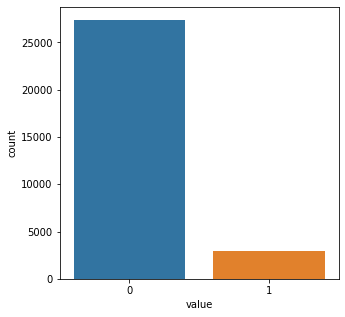

In [19]:
# removing irrelevant columns and unpivotting data
columns_to_drop = ['movie_title', 'release_date' , 'video_release_date', 'IMDb_URL', 'unknown']

df_items_unpivotted = df_items.copy()
df_items_unpivotted.drop(columns_to_drop, inplace=True, axis=1)
df_genres_onehot = df_items_unpivotted.set_index('movie id')

df_items_unpivotted = pd.melt(df_items_unpivotted, id_vars='movie id', value_vars=df_genres_onehot.columns)
df_items_unpivotted

f, axes = plt.subplots(1, 1,figsize=(5,5))
sns.countplot(df_items_unpivotted.value) 
plt.show()

**Movies genres distribution by the number of genres each movie has**

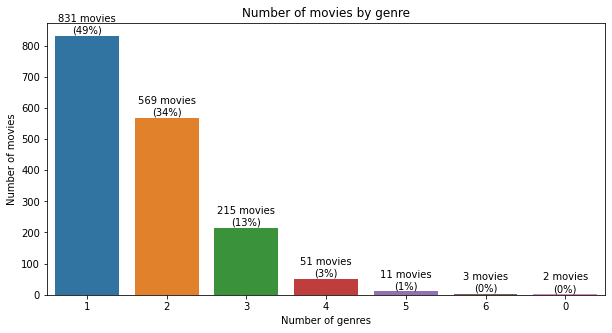

In [20]:
df_items_unpivotted_sum_of_genres = df_items_unpivotted.groupby('movie id')['value'].sum()

f, axes = plt.subplots(1, 1, figsize=(10, 5))

ax = sns.countplot(x=df_items_unpivotted_sum_of_genres,
                   order=df_items_unpivotted_sum_of_genres.value_counts(ascending=False).index)

# get the absolute values for each category
abs_values = df_items_unpivotted_sum_of_genres.value_counts(ascending=False)

# modify the labels to include the counts of each category
lbls = [f'{n} movies\n({p:.0f}%)' for n, p in zip(abs_values, abs_values/abs_values.sum()*100)]

# add the labels to the bars
for i, v in enumerate(ax.patches):
    ax.text(v.get_x() + v.get_width() / 2, v.get_height() + 1, lbls[i],
            fontsize=10, color='black', ha='center', va='bottom')

# add labels to the chart
ax.set_title('Number of movies by genre')
ax.set_xlabel('Number of genres')
ax.set_ylabel('Number of movies')

# display the chart
plt.show()

We can see that most of our one-hot matrix representing the genres of the movies is sparce, with most of the movies have only several genres they are belong to.

As we will later see, this lack of data will cause us problems. The reason is that movies with only 1 genre will be hard to compare, while movies with more than 3 genres will be easier to compare. Movies with a relatively large number of 0 genres will seem to be similar to each other, althgouh this is actually a difference! We will have the work on that to make sure this doesn't happen. 

Movies with small amount of genres are actually low in data, and it is worth considering even taking them out of the data or ignoring them. We can see that almost 50% of movies have only one genre!

**Movies' genres distribution**

[Text(0.5, 1.0, 'movies genre distribution')]

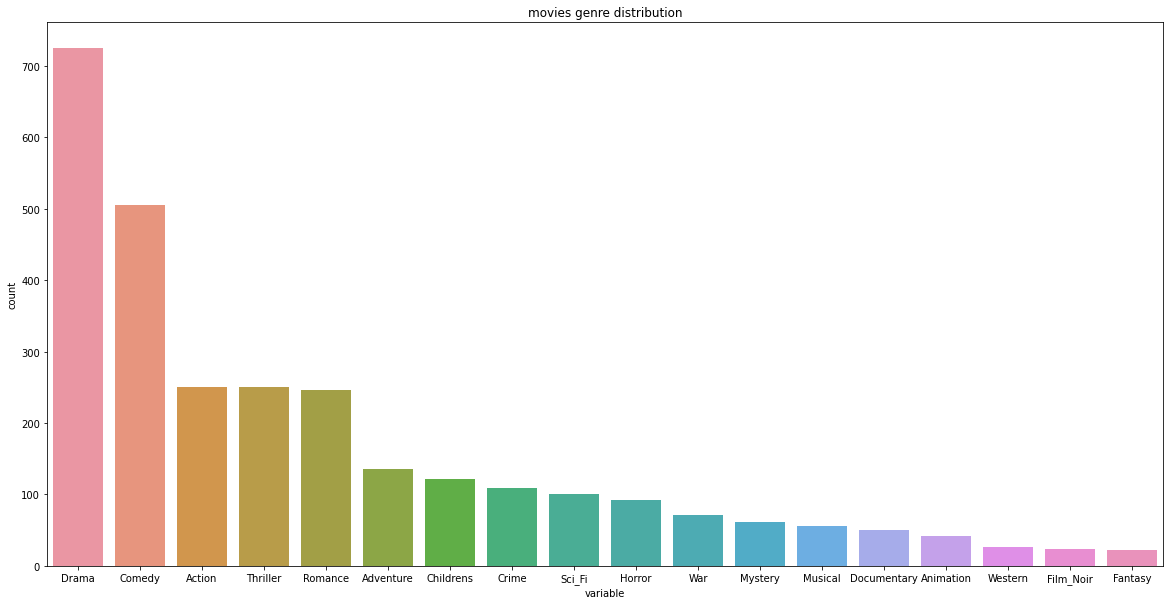

In [21]:
f, axes = plt.subplots(1, 1,figsize=(20, 10))
sns.countplot(data = df_items_unpivotted[df_items_unpivotted['value'] == 1], x = "variable",  order = df_items_unpivotted[df_items_unpivotted['value'] == 1]['variable'].value_counts().index).set(title = 'movies genre distribution')

[Text(0.5, 1.0, 'movies distribution by decade')]

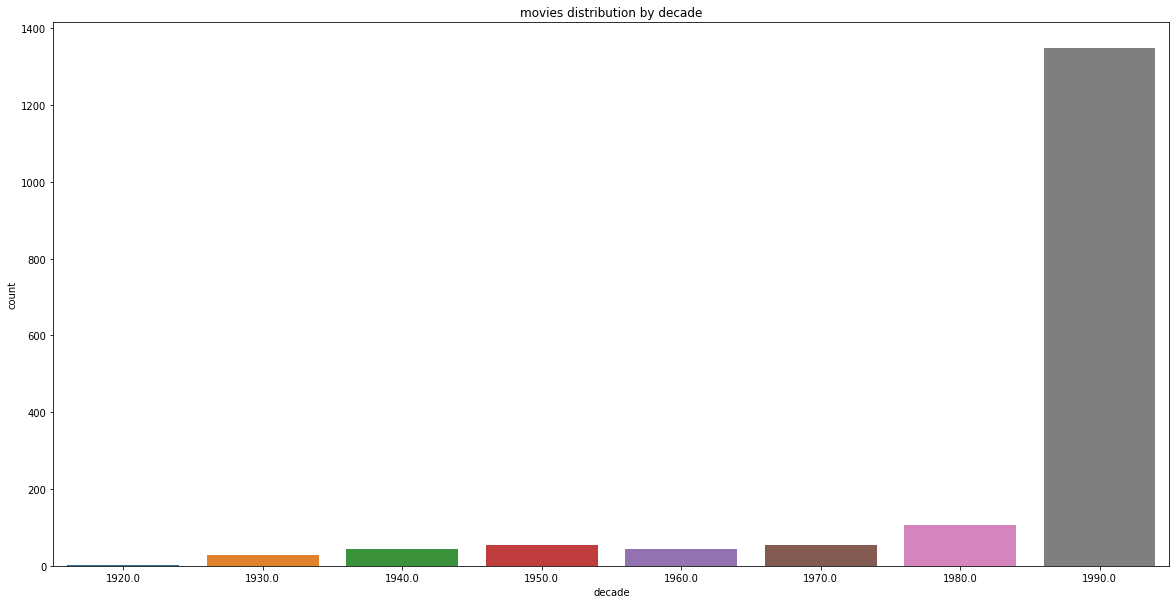

In [22]:
df_items_years = df_items.copy()
df_items_years['year'] = pd.DatetimeIndex(df_items_years['release_date']).year
df_items_years = df_items_years[df_items_years['release_date'].notna()]
df_items_years['decade'] = (df_items_years['year']//10)*10

f, axes = plt.subplots(1, 1,figsize=(20, 10))

sns.countplot(data = df_items_years, x = "decade").set(title = 'movies distribution by decade')

Latest year we have in the DB:

In [23]:
np.amax(df_items_years['year'].values)

1998.0

Earliest year we have in the DB:

In [24]:
np.amin(df_items_years['year'].values)

1922.0

##### Data pre-processing

Th model recommend newer movies rather than older ones. As such, in order to use the "age" of the movie, we will need to create it. We will use a specific day and measure the time that has passed in days from the release date to the given date. 

It would have made sense to use today's date, but since we see that the movie was released in 1998, it would make more sense to use some similar time to get "last videos released".

In order to use the time that has passed since the movie was released, we will calculate the "age" of the movie in days. That will enable us to use that in the model - since we know that users like new movies than older ones.

Due to the fact that the last movie was released in 1998, we will set the latest date in the dataset as the date of today, and calcaulte the age accorindgly. 

In [25]:
df_items["release_date"] = pd.to_datetime(df_items["release_date"], format='%d-%b-%Y')
latest_date = df_items["release_date"].max()
df_items["days_passed_from_release"] = (latest_date - df_items["release_date"]).dt.days
df_items

,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,days_passed_from_release
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1391.0
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1391.0
2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1391.0
3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1391.0
4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1391.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),1998-02-06,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,259.0
1678,1679,B. Monkey (1998),1998-02-06,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,259.0
1679,1680,Sliding Doors (1998),1998-01-01,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,295.0
1680,1681,You So Crazy (1994),1994-01-01,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1756.0


In [26]:
latest_date

Timestamp('1998-10-23 00:00:00')

[Text(0.5, 1.0, 'Movies by days passed from release')]

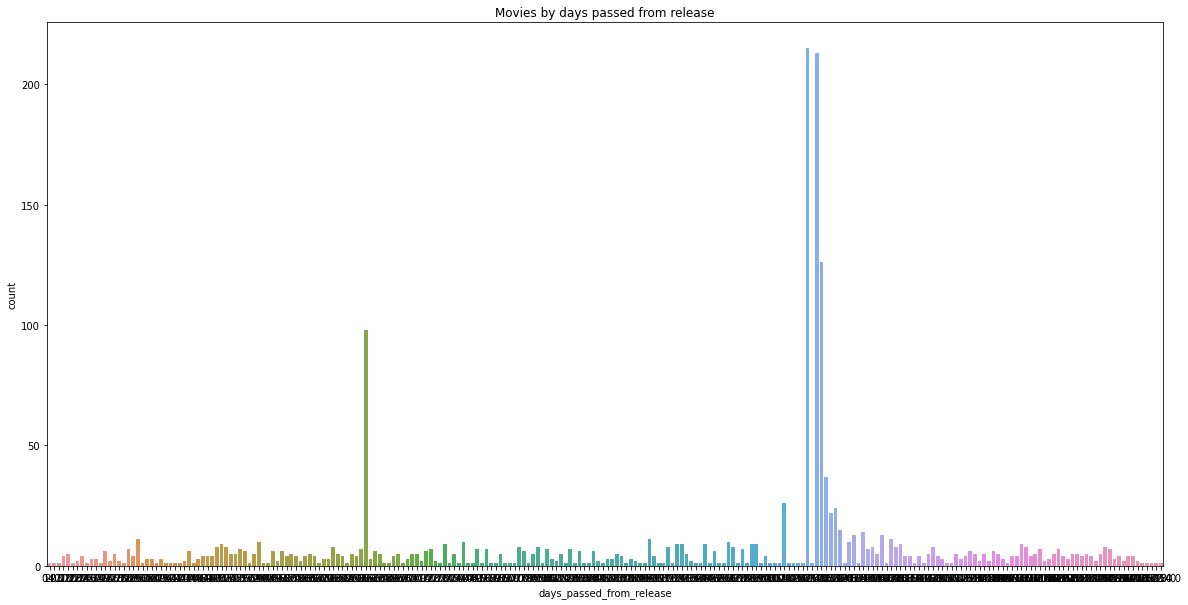

In [27]:
f, axes = plt.subplots(1, 1,figsize=(20, 10))
sns.countplot(data = df_items, x = "days_passed_from_release").set(title='Movies by days passed from release')

In the ranking phase of the moeel, we will use the age of movies normalized (sqaured and to the power of 2): 

In [28]:
# convert the days_passed_from_release column to float
df_items['days_passed_from_release'] = df_items['days_passed_from_release'].astype(float)

# normalize the days_passed_from_release column to values between 0 and 1
min_days = df_items['days_passed_from_release'].min()
max_days = df_items['days_passed_from_release'].max()
df_items['days_passed_from_release_normalized'] = (df_items['days_passed_from_release'] - min_days) / (max_days - min_days)

# raise the normalized days column to the power of 2
df_items['days_passed_from_release_normalized_squared'] = df_items['days_passed_from_release_normalized'] ** 2

# take the square root of the normalized days column
df_items['days_passed_from_release_normalized_sqrt'] = np.sqrt(df_items['days_passed_from_release_normalized'].clip(0, 1))

# display the updated dataframe
df_items.head()

,movie id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Mystery,Romance,Sci_Fi,Thriller,War,Western,days_passed_from_release,days_passed_from_release_normalized,days_passed_from_release_normalized_squared,days_passed_from_release_normalized_sqrt
0,1,Toy Story (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,1391.0,0.049583,0.002458,0.222672
1,2,GoldenEye (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,1,0,0,1391.0,0.049583,0.002458,0.222672
2,3,Four Rooms (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,1,0,0,1391.0,0.049583,0.002458,0.222672
3,4,Get Shorty (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,1391.0,0.049583,0.002458,0.222672
4,5,Copycat (1995),1995-01-01,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,1,0,0,1391.0,0.049583,0.002458,0.222672


#### Ratings df

##### Loading data

In [29]:
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
df_ratings

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [30]:
df_ratings.shape

(100000, 4)

##### Creating the ratings matrix

In [31]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
ratings

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
ratings.shape

(943, 1682)

##### Data Exploration and analysis

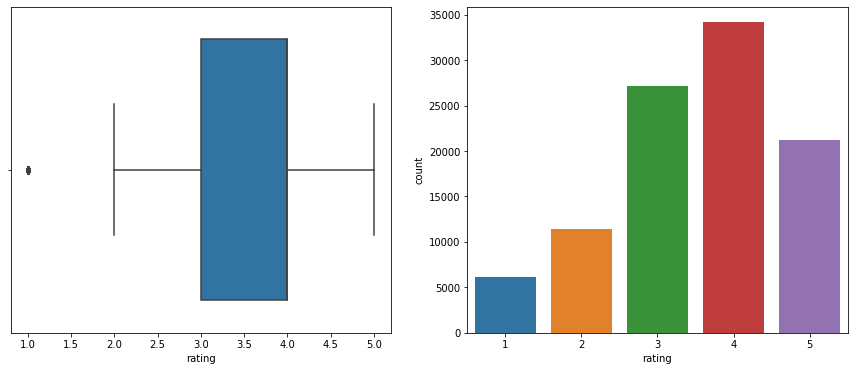

In [33]:
f, axes = plt.subplots(1, 2,figsize=(15,6))
sns.boxplot(df_ratings.rating,ax=axes[0])
sns.countplot(df_ratings.rating,ax=axes[1])
plt.show()

The graph to the left shows us that 50% of the movies have rankes of between 3 to 4 stars, and that matches the graph to the right, showing that 3 and 4 star rating are the most popular ones. We can also see that ratings of 1 are outliers in the data and almost do not appear.

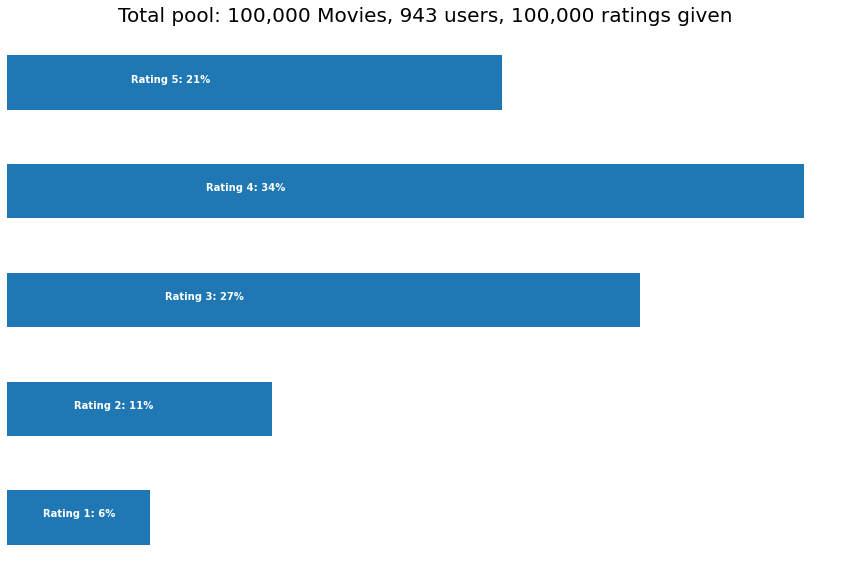

In [34]:
p = df_ratings.groupby('rating')['rating'].agg(['count'])
movie_count = df_ratings.item_id.count()
cust_count = df_ratings.user_id.nunique() 
rating_count = df_ratings.user_id.count()

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} users, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

**Distribution of number of ratings per user\item**

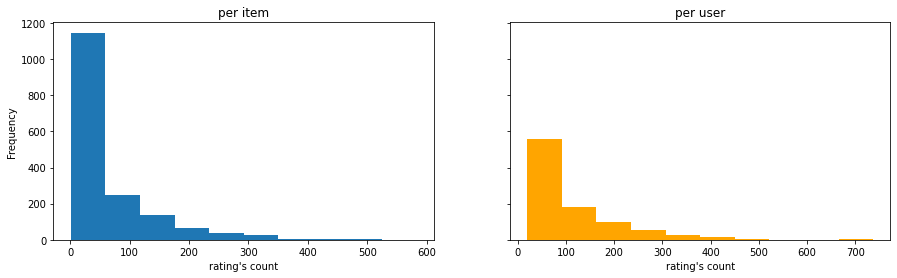

In [35]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0])
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('rating\'s count')
ax[1].set_xlabel('rating\'s count');

**Distribution of average rating value  per user\item**

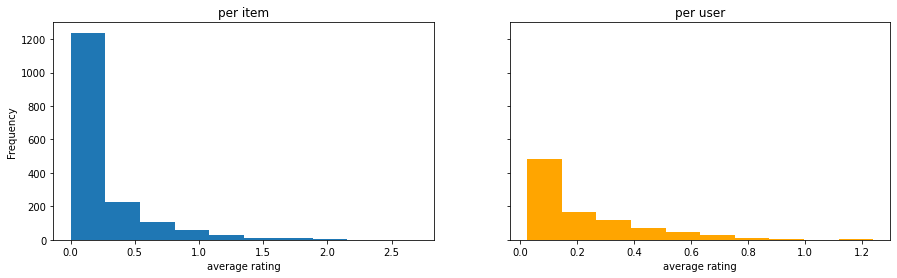

In [36]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.mean(axis=0).plot.hist(ax=ax[0])
ratings.mean(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('average rating')
ax[1].set_xlabel('average rating');

**Movie ratings aggregated by user**

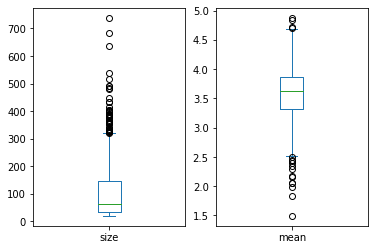

In [37]:
userRatingsAggr = df_ratings.groupby(['user_id']).agg({'rating': [np.size, np.mean]})
userRatingsAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
userRatingsAggr['rating'].plot(kind='box', subplots=True)
plt.show();

**Genres**

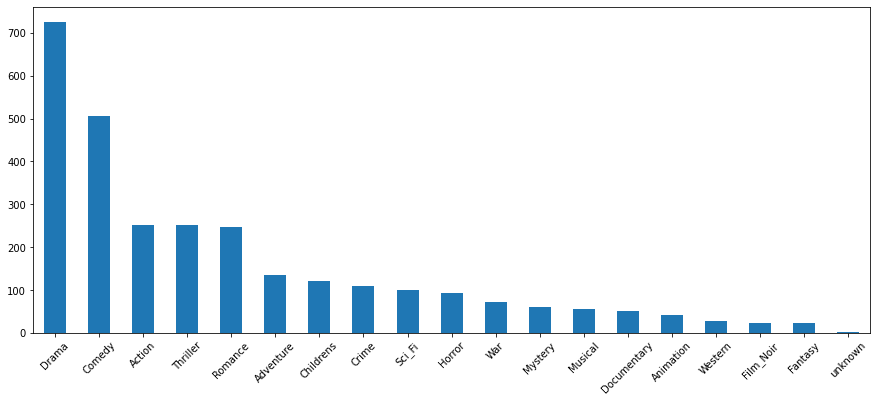

In [38]:
plt.figure(figsize=(15,6))
df_items.iloc[:,5:-4].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

##### Data pre-processing

Using the ratings df, we will (1) change the timestamp to be in date time so we could calculate the "age" of the video - meaning the time that has passed since watching - and choose the n latest videos watched, and (2) filter out the movies that were rated less than our definiton, here we will define 3 stars. Later on, since the paper deals with implicit ratings, we will not use the ratings themselves, but just the movies with positive interactions. 

In [39]:
# converting the timestamps to dates and calculating the days that passed since rating/watching 
df_ratings['date_watched'] = pd.to_datetime(df_ratings['timestamp'], unit='s').dt.date
latest_date = df_ratings['date_watched'].max()
df_ratings["days_passed_from_watching"] = (latest_date - df_ratings["date_watched"]).dt.days

# # filter out all movies with ratings less than 3 
df_ratings

,user_id,item_id,rating,timestamp,date_watched,days_passed_from_watching
0,196,242,3,881250949,1997-12-04,139
1,186,302,3,891717742,1998-04-04,18
2,22,377,1,878887116,1997-11-07,166
3,244,51,2,880606923,1997-11-27,146
4,166,346,1,886397596,1998-02-02,79
...,...,...,...,...,...,...
99995,880,476,3,880175444,1997-11-22,151
99996,716,204,5,879795543,1997-11-17,156
99997,276,1090,1,874795795,1997-09-20,214
99998,13,225,2,882399156,1997-12-17,126


Since in the ranking phase we will need the normalized days passed from watching, we will do it now -

In [40]:
min_days = df_ratings['days_passed_from_watching'].min()
max_days = df_ratings['days_passed_from_watching'].max()
df_ratings['days_passed_from_watching_normalized'] = (df_ratings['days_passed_from_watching'] - min_days) / (max_days - min_days)

df_ratings

,user_id,item_id,rating,timestamp,date_watched,days_passed_from_watching,days_passed_from_watching_normalized
0,196,242,3,881250949,1997-12-04,139,0.649533
1,186,302,3,891717742,1998-04-04,18,0.084112
2,22,377,1,878887116,1997-11-07,166,0.775701
3,244,51,2,880606923,1997-11-27,146,0.682243
4,166,346,1,886397596,1998-02-02,79,0.369159
...,...,...,...,...,...,...,...
99995,880,476,3,880175444,1997-11-22,151,0.705607
99996,716,204,5,879795543,1997-11-17,156,0.728972
99997,276,1090,1,874795795,1997-09-20,214,1.000000
99998,13,225,2,882399156,1997-12-17,126,0.588785


### Data-set Creation for the Anchor paper model

#### Changing explicit ratings to implicit

Since the paper is based on an implicit model and not explicit (meaning that we will not use the 1-5 ratings but only whether a user has liked a video or not) - we will transform the data into a different strucutre. This will also enable us to send this data later to the NN and start the training process.

If so, we need to change the data to be in a way we could afterwards embed it:


#### Creating the data for the Candidate Generation network

The data for the model needs to be as follows - each inspection is a user with its watching history.

The data we will be using is as follows - each sample is a user that will have the following features - 
1. The user's watching history - a list including IDs of the latest videos watched by the user (meaning that were rated as 3 and above)
2. (The user's search history) - a list with the name of the latest videos searched by the user (NOTE - in the paper they do include the user's last searches, but since we don't have the actual searches we decided to use the names of the movies as search history. However, due to the fact that the names should be chnaged into some categorial order - that brings us to the same result as using the IDs of the movies in (1), and will be addressed in our suggestion for improvement in the second part of the notebook).
3. Dislike data - the paper also discussed using disliked data - so we will also include that in our model. 
3. "Geographic data" - we will use the user's age, gender, and occupation, instead of actual geographic location such as geographic region and device that were mentioned in the paper. As suggested in the article - continuous variables such as user's age and movie age, we will normalize and use the root and squared. As for the gender and occupation, we will categorize them to be able to enter them into the model. 
4. Example age - the time passed since releasing in days (normalized, and normalized squared and rooted)

The y label here - the next movie the user will watch. (@explain how did we come up with the y label)

In [41]:
min_rating_to_like = 3

# columns for data: user_id, likes, dislikes, liked_movies_days_from_release, liked_movies_search_name, age, gender, occupation, next_movie_to_watch
# still need: liked_movies_days_from_release, liked_movies_search_name, geners
result = pd.DataFrame()
user_id = ratings.index.values
all_liked_movies = df_ratings[df_ratings["rating"] >= min_rating_to_like]
liked_movie_names = all_liked_movies.merge(df_items, left_on='item_id', right_on='movie id').groupby('user_id')['movie_title', 'date_watched'].apply(lambda x: x.sort_values("date_watched", ascending=False)).reset_index().groupby("user_id")["movie_title"].apply(list)
all_liked_movies = all_liked_movies.groupby('user_id')['item_id', 'date_watched'].apply(lambda x: x.sort_values("date_watched", ascending=False)).reset_index().groupby("user_id")["item_id"].apply(list)
new_df_items = df_items.set_index("movie id")
days_passed_from_release_normalized = [list(new_df_items.loc[all_liked_movies.values[i]]["days_passed_from_release_normalized"].values) for i in range(len(all_liked_movies))]
movie_geners = [list(new_df_items.loc[all_liked_movies.values[i]].iloc[:, 5:-4].columns[(new_df_items.loc[all_liked_movies.values[i]].iloc[:, 5:-4].sum() > 0)]) for i in range(len(all_liked_movies))]
likes = all_liked_movies.apply(lambda x:x[:-1]).values
movie_name_likes = all_liked_movies.apply(lambda x:x[:-1]).values
next_movie_to_watch = all_liked_movies.apply(lambda x:x[-1]).values
all_liked_movies = all_liked_movies.reset_index()
all_liked_movies = all_liked_movies.rename(columns={"item_id": "likes"})
dislikes = df_ratings[df_ratings["rating"] < min_rating_to_like].groupby('user_id')['item_id'].apply(list).reset_index()
dislikes = dislikes.rename(columns={"item_id": "dislikes"})
result = all_liked_movies.merge(dislikes, left_on='user_id', right_on='user_id', how="outer")
result = result.merge(liked_movie_names, left_on='user_id', right_on='user_id', how="outer")
result = result.merge(df_users[["user_id", "age"]], left_on='user_id', right_on='user_id', how="outer")
result = result.merge(df_users[["user_id", "gender"]], left_on='user_id', right_on='user_id', how="outer")
result = result.merge(df_users[["user_id", "occupation"]], left_on='user_id', right_on='user_id', how="outer")
result = result.rename(columns={"movie_title": "liked_movie_names"})
result["geners"] = movie_geners
result["days_passed_from_release_normalized"] = days_passed_from_release_normalized
result["next_movie_to_watch"] = next_movie_to_watch
result['dislikes'] = result['dislikes'].apply(lambda x: [] if x is np.nan else x)
result.head()

,user_id,likes,dislikes,liked_movie_names,age,gender,occupation,geners,days_passed_from_release_normalized,next_movie_to_watch
0,1,"[256, 242, 111, 5, 171, 270, 189, 32, 209, 6, ...","[155, 266, 74, 27, 260, 145, 140, 225, 120, 10...","[Kolya (1996), Copycat (1995), Delicatessen (1...",24,M,technician,"[Action, Adventure, Animation, Childrens, Come...","[0.017466314963998003, 0.022706209453197405, 0...",257
1,2,"[304, 289, 300, 310, 281, 316, 272, 308, 269, ...","[314, 315, 294, 309, 10]","[FairyTale: A True Story (1997), Good Will Hun...",53,F,other,"[Action, Adventure, Animation, Childrens, Come...","[0.027447066371996863, 0.023775575675482996, 0...",296
2,3,"[343, 331, 340, 347, 344, 271, 322, 181, 329, ...","[335, 245, 337, 323, 294, 332, 341, 300, 324, ...","[Cop Land (1997), Murder at 1600 (1997), Proph...",23,M,writer,"[Action, Adventure, Comedy, Crime, Documentary...","[0.023526056890283024, 0.013973051971198403, 0...",346
3,4,"[264, 328, 360, 362, 359, 324, 327, 11, 329, 2...",[358],"[Cop Land (1997), Ulee's Gold (1997), Blues Br...",24,M,technician,"[Action, Adventure, Comedy, Crime, Documentary...","[0.01522064589719826, 0.015719683467598205, 0....",301
4,5,"[40, 163, 24, 194, 189, 426, 101, 94, 169, 408...","[439, 225, 110, 454, 424, 376, 231, 377, 394, ...","[To Wong Foo, Thanks for Everything! Julie New...",33,F,other,"[Action, Adventure, Animation, Childrens, Come...","[0.04958294717330862, 0.3229842446709917, 0.03...",174


In [42]:
############ REMOVED THE YEAR FROM "latest_n_movies_searched_name" FOR WORD2VEC ############

import re
year_pattern = re.compile(r'\s*\(\d{4}\)')

sentences = result["liked_movie_names"].values

# Iterate over the sentences and remove the year from each movie name
for i in range(len(sentences)):
    for j in range(len(sentences[i])):
        sentences[i][j] = re.sub(year_pattern, '', sentences[i][j])

result["liked_movie_names"] = sentences
result.head()

,user_id,likes,dislikes,liked_movie_names,age,gender,occupation,geners,days_passed_from_release_normalized,next_movie_to_watch
0,1,"[256, 242, 111, 5, 171, 270, 189, 32, 209, 6, ...","[155, 266, 74, 27, 260, 145, 140, 225, 120, 10...","[Kolya, Copycat, Delicatessen, When the Cats A...",24,M,technician,"[Action, Adventure, Animation, Childrens, Come...","[0.017466314963998003, 0.022706209453197405, 0...",257
1,2,"[304, 289, 300, 310, 281, 316, 272, 308, 269, ...","[314, 315, 294, 309, 10]","[FairyTale: A True Story, Good Will Hunting, R...",53,F,other,"[Action, Adventure, Animation, Childrens, Come...","[0.027447066371996863, 0.023775575675482996, 0...",296
2,3,"[343, 331, 340, 347, 344, 271, 322, 181, 329, ...","[335, 245, 337, 323, 294, 332, 341, 300, 324, ...","[Cop Land, Murder at 1600, Prophecy II, The, M...",23,M,writer,"[Action, Adventure, Comedy, Crime, Documentary...","[0.023526056890283024, 0.013973051971198403, 0...",346
3,4,"[264, 328, 360, 362, 359, 324, 327, 11, 329, 2...",[358],"[Cop Land, Ulee's Gold, Blues Brothers 2000, W...",24,M,technician,"[Action, Adventure, Comedy, Crime, Documentary...","[0.01522064589719826, 0.015719683467598205, 0....",301
4,5,"[40, 163, 24, 194, 189, 426, 101, 94, 169, 408...","[439, 225, 110, 454, 424, 376, 231, 377, 394, ...","[To Wong Foo, Thanks for Everything! Julie New...",33,F,other,"[Action, Adventure, Animation, Childrens, Come...","[0.04958294717330862, 0.3229842446709917, 0.03...",174


Now, in order to use the gender and occupation fields, we need to categorize them -

In [43]:
le = LabelEncoder()

result['gender'] = le.fit_transform(result['gender'])  

occupations = result['occupation'].unique().tolist()
occupation2occupation_encoded = {x: i for i, x in enumerate(occupations)}

result["occupation"] = result["occupation"].map(occupation2occupation_encoded)
result.head(5)

,user_id,likes,dislikes,liked_movie_names,age,gender,occupation,geners,days_passed_from_release_normalized,next_movie_to_watch
0,1,"[256, 242, 111, 5, 171, 270, 189, 32, 209, 6, ...","[155, 266, 74, 27, 260, 145, 140, 225, 120, 10...","[Kolya, Copycat, Delicatessen, When the Cats A...",24,1,0,"[Action, Adventure, Animation, Childrens, Come...","[0.017466314963998003, 0.022706209453197405, 0...",257
1,2,"[304, 289, 300, 310, 281, 316, 272, 308, 269, ...","[314, 315, 294, 309, 10]","[FairyTale: A True Story, Good Will Hunting, R...",53,0,1,"[Action, Adventure, Animation, Childrens, Come...","[0.027447066371996863, 0.023775575675482996, 0...",296
2,3,"[343, 331, 340, 347, 344, 271, 322, 181, 329, ...","[335, 245, 337, 323, 294, 332, 341, 300, 324, ...","[Cop Land, Murder at 1600, Prophecy II, The, M...",23,1,2,"[Action, Adventure, Comedy, Crime, Documentary...","[0.023526056890283024, 0.013973051971198403, 0...",346
3,4,"[264, 328, 360, 362, 359, 324, 327, 11, 329, 2...",[358],"[Cop Land, Ulee's Gold, Blues Brothers 2000, W...",24,1,0,"[Action, Adventure, Comedy, Crime, Documentary...","[0.01522064589719826, 0.015719683467598205, 0....",301
4,5,"[40, 163, 24, 194, 189, 426, 101, 94, 169, 408...","[439, 225, 110, 454, 424, 376, 231, 377, 394, ...","[To Wong Foo, Thanks for Everything! Julie New...",33,0,1,"[Action, Adventure, Animation, Childrens, Come...","[0.04958294717330862, 0.3229842446709917, 0.03...",174


We will now categorize the genres for using it in our improved model. Each movie will be coded into different number, so users who liked similar genres will get similar recommendataions. The indexes are between 1 to the number of genres there are. 

In [44]:
uniq_geners = df_items.columns[6:-4].values
geners2geners_encoded = {x: i for i, x in enumerate(uniq_geners)}
for x in range(result.shape[0]):
  result["geners"].iloc[x] = [geners2geners_encoded[result["geners"].iloc[x][y]] for y in range(len(result["geners"].iloc[x]))] #.map(geners2geners_encoded)

result.head()

,user_id,likes,dislikes,liked_movie_names,age,gender,occupation,geners,days_passed_from_release_normalized,next_movie_to_watch
0,1,"[256, 242, 111, 5, 171, 270, 189, 32, 209, 6, ...","[155, 266, 74, 27, 260, 145, 140, 225, 120, 10...","[Kolya, Copycat, Delicatessen, When the Cats A...",24,1,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.017466314963998003, 0.022706209453197405, 0...",257
1,2,"[304, 289, 300, 310, 281, 316, 272, 308, 269, ...","[314, 315, 294, 309, 10]","[FairyTale: A True Story, Good Will Hunting, R...",53,0,1,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.027447066371996863, 0.023775575675482996, 0...",296
2,3,"[343, 331, 340, 347, 344, 271, 322, 181, 329, ...","[335, 245, 337, 323, 294, 332, 341, 300, 324, ...","[Cop Land, Murder at 1600, Prophecy II, The, M...",23,1,2,"[0, 1, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16]","[0.023526056890283024, 0.013973051971198403, 0...",346
3,4,"[264, 328, 360, 362, 359, 324, 327, 11, 329, 2...",[358],"[Cop Land, Ulee's Gold, Blues Brothers 2000, W...",24,1,0,"[0, 1, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16]","[0.01522064589719826, 0.015719683467598205, 0....",301
4,5,"[40, 163, 24, 194, 189, 426, 101, 94, 169, 408...","[439, 225, 110, 454, 424, 376, 231, 377, 394, ...","[To Wong Foo, Thanks for Everything! Julie New...",33,0,1,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.04958294717330862, 0.3229842446709917, 0.03...",174


#### Create the output layer of the anchor paper model

As mentioned, the paper views recommendation as a complex multi-class classification task, where the objective is to correctly identify a specific video watched by a user at a given time, among a large corpus of millions of videos. Thus, the last layer of the model should include as many neurons as the number of possibilities the user can have. Meaning - all the movies we have a positive interaction with. 

We will use the last column to create the labels for the last layer of the model:

In [45]:
no_of_output_layer_options = result['next_movie_to_watch'].max()
no_of_output_layer_options

1600

#### Creating the data for the Ranking layer

In the ranking phase, we also add additional features, and make normalization for continuous features. Since we don't have all the other information discussed in the article, we will normalize what we do have and add the additional engineered features (such as x^2 and sqrt(x)). Since all we have is the user's age, we will do it -

In [46]:
# convert the age column to float
result['age'] = result['age'].astype(float)

# normalize the age column to values between 0 and 1
min_age = result['age'].min()
max_age = result['age'].max()
result['age_normalized'] = (result['age'] - min_age) / (max_age - min_age)

result.head()

,user_id,likes,dislikes,liked_movie_names,age,gender,occupation,geners,days_passed_from_release_normalized,next_movie_to_watch,age_normalized
0,1,"[256, 242, 111, 5, 171, 270, 189, 32, 209, 6, ...","[155, 266, 74, 27, 260, 145, 140, 225, 120, 10...","[Kolya, Copycat, Delicatessen, When the Cats A...",24.0,1,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.017466314963998003, 0.022706209453197405, 0...",257,0.257576
1,2,"[304, 289, 300, 310, 281, 316, 272, 308, 269, ...","[314, 315, 294, 309, 10]","[FairyTale: A True Story, Good Will Hunting, R...",53.0,0,1,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.027447066371996863, 0.023775575675482996, 0...",296,0.696970
2,3,"[343, 331, 340, 347, 344, 271, 322, 181, 329, ...","[335, 245, 337, 323, 294, 332, 341, 300, 324, ...","[Cop Land, Murder at 1600, Prophecy II, The, M...",23.0,1,2,"[0, 1, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16]","[0.023526056890283024, 0.013973051971198403, 0...",346,0.242424
3,4,"[264, 328, 360, 362, 359, 324, 327, 11, 329, 2...",[358],"[Cop Land, Ulee's Gold, Blues Brothers 2000, W...",24.0,1,0,"[0, 1, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16]","[0.01522064589719826, 0.015719683467598205, 0....",301,0.257576
4,5,"[40, 163, 24, 194, 189, 426, 101, 94, 169, 408...","[439, 225, 110, 454, 424, 376, 231, 377, 394, ...","[To Wong Foo, Thanks for Everything! Julie New...",33.0,0,1,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.04958294717330862, 0.3229842446709917, 0.03...",174,0.393939


In [47]:
user_movies_watched_id = result["likes"].values
max_id_liked = 0
max_id_liked = [max(user_movies_watched_id[i]) for i in range(len(user_movies_watched_id)) if max(user_movies_watched_id[i]) > max_id_liked]
max_id_liked = max(max_id_liked)
max_id_liked

1682

In [48]:
user_movies_watched_id = result["dislikes"].values
max_id_disliked = 0
max_id_disliked = [max(user_movies_watched_id[i]) for i in range(len(user_movies_watched_id)) if len(user_movies_watched_id[i]) if max(user_movies_watched_id[i]) > max_id_disliked]
max_id_disliked = max(max_id_disliked)
max_id_disliked

1680

In [49]:
user_gener = result["geners"].values
max_geners = 0
max_geners = [max(user_gener[i]) for i in range(len(user_gener)) if len(user_gener[i]) if max(user_gener[i]) > max_geners]
max_geners = max(max_geners)
max_geners

17

Split result df to train and test

In [50]:
from sklearn.model_selection import train_test_split

# assuming your data frame is called "df"
X = result.drop(['next_movie_to_watch'], axis=1)  # input features
y = result['next_movie_to_watch']  # output label

# split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = X_train.copy()
train_data["next_movie_to_watch"] = y_train.values
test_data = X_test.copy()
test_data["next_movie_to_watch"] = y_test.values
train_data.head()

,user_id,likes,dislikes,liked_movie_names,age,gender,occupation,geners,days_passed_from_release_normalized,age_normalized,next_movie_to_watch
244,245,"[1028, 1047, 151, 258, 210, 596, 300, 597, 756...","[94, 473, 240, 133, 894]","[Star Trek: First Contact, Grumpier Old Men, J...",22.0,1,5,"[0, 1, 2, 3, 4, 7, 8, 11, 13, 14, 15, 16]","[0.04958294717330862, 0.029692735438796608, 0....",0.227273,717
82,83,"[243, 471, 298, 846, 322, 300, 234, 233, 663, ...","[78, 301, 640, 413, 364, 631, 254, 543, 1101, ...","[Face/Off, Courage Under Fire, To Gillian on H...",40.0,1,1,"[0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 1...","[0.021209096741997575, 0.03418407357239609, 0....",0.500000,1049
316,317,"[326, 264, 354, 879, 288, 299, 355, 748, 322, ...","[323, 678, 683]","[Murder at 1600, Hoodlum, Wedding Singer, The,...",22.0,1,4,"[0, 1, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16]","[0.023526056890283024, 0.01522064589719826, 0....",0.227273,260
350,351,"[343, 895, 327, 312, 751, 754, 750, 989, 1105,...","[340, 880]","[Titanic, Midnight in the Garden of Good and E...",61.0,1,7,"[0, 1, 2, 3, 4, 5, 7, 10, 11, 12, 13, 14, 15, 16]","[0.023526056890283024, 0.023526056890283024, 0...",0.818182,304
465,466,"[181, 184, 288, 55, 187, 98, 68, 11, 908, 174,...","[308, 354, 128, 349, 321, 2, 748, 682, 269, 95...","[L.A. Confidential, Glory, Edge, The, Kiss Me,...",22.0,1,5,"[0, 1, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17]","[0.020959577956797603, 0.07560419191559135, 0....",0.227273,92


### Creating the data for the Improved / Suggested Model - favorate genres for each user

In our improved model, we suggested to take into account also the preferred genres of eack user. For that, we will create an array, that for each user will include its favorite genres. Firstly we will turn every genre into a number that represents it, and then we will create an array for each user that will present the preferable genres. 

In [51]:
# Custom function to group ratings by rating value
def group_ratings_by_value(ratings):
    grouped_ratings = ratings.groupby('rating')['item_id'].apply(list)
    return pd.Series({
        'movies_rated_5': grouped_ratings.get(5, []),
        'movies_rated_4': grouped_ratings.get(4, []),
        'movies_rated_3': grouped_ratings.get(3, []),
    })

# Group ratings by user and apply custom function
df_user_ratings = df_ratings.groupby('user_id').apply(group_ratings_by_value)

# Reset index to make user_id a column
df_user_ratings = df_user_ratings.reset_index()

results_for_improved = pd.merge(df_user_ratings, result, on='user_id')
results_for_improved

,user_id,movies_rated_5,movies_rated_4,movies_rated_3,likes,dislikes,liked_movie_names,age,gender,occupation,geners,days_passed_from_release_normalized,next_movie_to_watch,age_normalized
0,1,"[202, 171, 253, 113, 64, 228, 114, 221, 60, 17...","[61, 33, 160, 20, 265, 47, 222, 227, 90, 121, ...","[189, 117, 17, 92, 31, 70, 159, 272, 125, 215,...","[256, 242, 111, 5, 171, 270, 189, 32, 209, 6, ...","[155, 266, 74, 27, 260, 145, 140, 225, 120, 10...","[Kolya, Copycat, Delicatessen, When the Cats A...",24.0,1,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[0.017466314963998003, 0.022706209453197405, 0...",257,0.257576
1,2,"[251, 50, 316, 313, 242, 283, 311, 100, 127, 2...","[292, 297, 13, 303, 257, 301, 279, 299, 277, 2...","[290, 312, 281, 280, 308, 307, 298, 19, 258, 3...","[304, 289, 300, 310, 281, 316, 272, 308, 269, ...","[314, 315, 294, 309, 10]","[FairyTale: A True Story, Good Will Hunting, R...",53.0,0,1,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.027447066371996863, 0.023775575675482996, 0...",296,0.696970
2,3,"[328, 321, 320, 347, 340, 346]","[331, 318, 348, 327, 260, 342, 329, 181, 344]","[343, 334, 350, 345, 299, 351, 307, 354, 349, ...","[343, 331, 340, 347, 344, 271, 322, 181, 329, ...","[335, 245, 337, 323, 294, 332, 341, 300, 324, ...","[Cop Land, Murder at 1600, Prophecy II, The, M...",23.0,1,2,"[0, 1, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 16]","[0.023526056890283024, 0.013973051971198403, 0...",346,0.242424
3,4,"[303, 361, 294, 50, 354, 300, 258, 329, 327, 3...","[357, 260, 288, 271, 11]","[264, 356, 328, 210]","[264, 328, 360, 362, 359, 324, 327, 11, 329, 2...",[358],"[Cop Land, Ulee's Gold, Blues Brothers 2000, W...",24.0,1,0,"[0, 1, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16]","[0.01522064589719826, 0.015719683467598205, 0....",301,0.257576
4,5,"[382, 436, 42, 153, 109, 100, 89, 433, 428, 20...","[17, 1, 211, 62, 24, 423, 267, 222, 173, 422, ...","[2, 363, 98, 102, 407, 384, 445, 426, 403, 154...","[40, 163, 24, 194, 189, 426, 101, 94, 169, 408...","[439, 225, 110, 454, 424, 376, 231, 377, 394, ...","[To Wong Foo, Thanks for Everything! Julie New...",33.0,0,1,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[0.04958294717330862, 0.3229842446709917, 0.03...",174,0.393939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,939,"[689, 476, 121, 1190, 222, 326, 1051, 1277, 22...","[258, 1054, 409, 993, 1023, 597, 411, 717, 841...","[106, 818, 934, 424, 254, 252]","[106, 1028, 285, 411, 15, 717, 283, 9, 280, 59...","[931, 890, 266, 680]","[Star Trek: First Contact, Secrets & Lies, Emm...",26.0,0,5,"[0, 1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 1...","[0.036572324802167246, 0.04958294717330862, 0....",471,0.287879
939,940,"[96, 194, 8, 56, 95, 855, 427, 300, 482, 709, ...","[272, 655, 315, 66, 172, 147, 170, 174, 317, 8...","[193, 568, 14, 205, 873, 289, 181, 474, 751, 7...","[316, 354, 873, 879, 193, 382, 651, 516, 70, 1...","[153, 355, 610, 1401, 319, 549, 4, 343, 358, 7...","[Peacemaker, The, Picture Perfect, Wedding Sin...",32.0,1,4,"[0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 1...","[0.010836244385827334, 0.008982676267198973, 0...",313,0.378788
940,941,"[124, 117, 181, 298, 408, 919, 1]","[147, 993, 258, 7, 475, 257, 15, 455, 300, 294...","[763, 273]","[147, 124, 294, 1, 273, 919, 300, 408, 298, 76...","[222, 358]","[Toy Story, Return of the Jedi, Lone Star, Wai...",20.0,1,5,"[0, 1, 2, 3, 4, 5, 7, 11, 12, 13, 14, 15, 16]","[0.026662864475654097, 0.03044129179439652, 0....",1007,0.196970
941,942,"[423, 427, 347, 304, 193, 31, 131, 500, 172, 6...","[117, 200, 604, 261, 487, 584, 511, 969, 479, ...","[323, 615, 539, 313, 362, 892, 322, 183, 328, ...","[117, 174, 310, 265, 705, 79, 99, 662, 272, 31...",[269],"[Aladdin, Roman Holiday, As Good As It Gets, B...",48.0,0,11,"[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[0.030940329364796463, 0.23183859699151635, 0....",259,0.621212


## Creating the data for the MF model

We will use the ratings matrix for the MF method:

In [52]:
ratings

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,0.0,0.0,0.0,2.0,0.0,0.0,4.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,5.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


split into train and test:

In [53]:
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test

fold = 1
train,test = getfulldf(*fold2df(1))

train.shape, test.shape

((943, 1682), (943, 1682))

Initiate results df

In [54]:
eval_results_df = pd.DataFrame(columns = ['model', 'metric', 'topk', 'score', 'time']) 
eval_results_df

,model,metric,topk,score,time


# Anchor Paper & Evaluation

### Baseline algorithm description

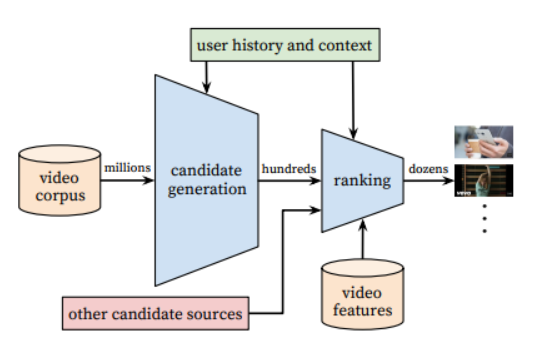

After we've prepared our data to fit the model described in the article, we will now build the neural network. As mentioned in class, and since we have a relatively small number of movies, and the networks are pretty similar in their structure, we will include only one network that will receive all relevant information. The one network will recieve features for both the Can Gen and the Ranking networks.

### Defining Model Architecture & Compiling

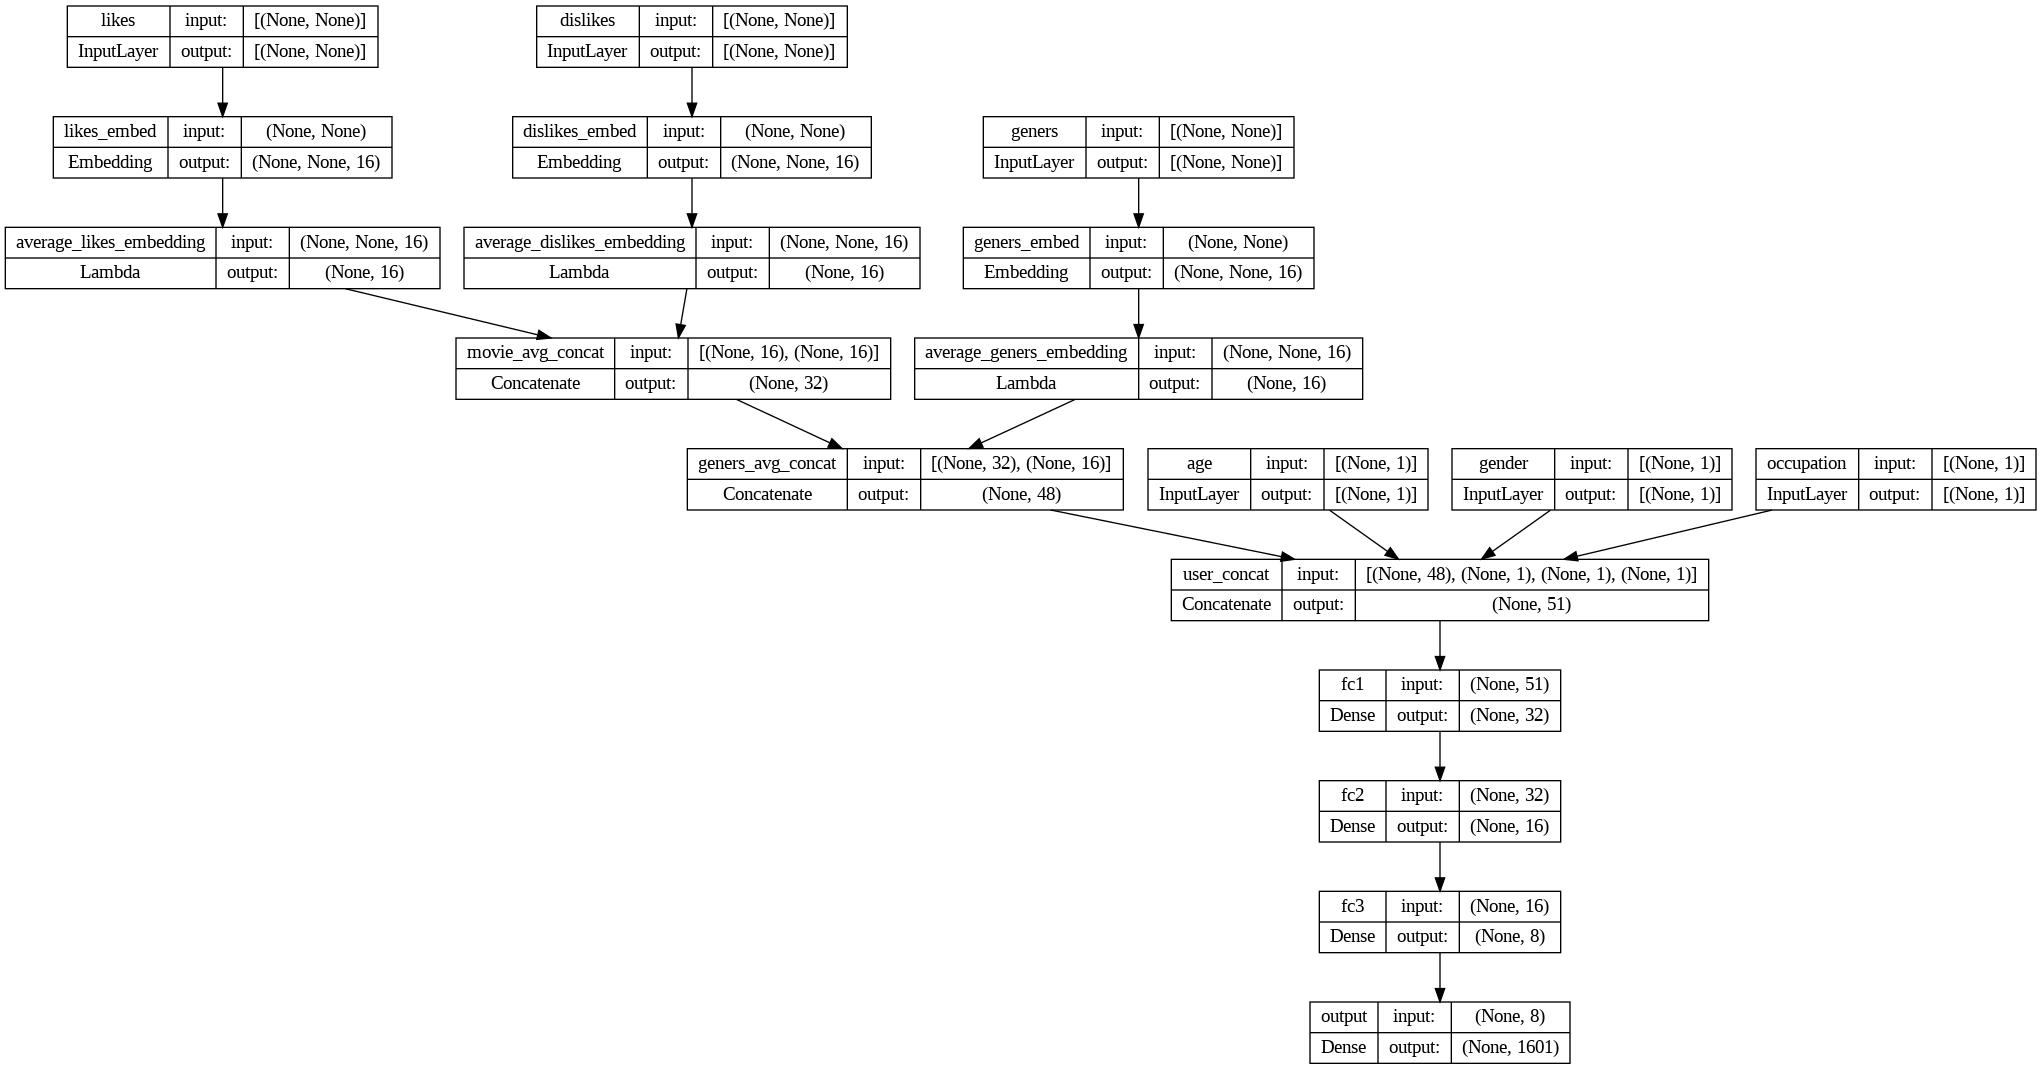

In [55]:
# # Constants
EMBEDDING_DIMS = 64 # number of dimensions in the embeddings, we will need to get this as a hyper-param

def get_baseline_model(embedding_dims = 32, learning_rate = 0.01, mode = 'train', no_of_output_layer_options = no_of_output_layer_options,
                       max_id_liked = max_id_liked, max_id_disliked=max_id_disliked, max_geners=max_geners, dense_sizes=[32, 16, 8]):
    # Define input layers
    movie_liked_id_input = Input(shape=(None,), name='likes')
    movie_disliked_id_input = Input(shape=(None,), name='dislikes')
    geners_input = Input(shape=(None,), name='geners')


    age_input = Input(shape=(1,), name='age')
    gender_input = Input(shape=(1,), name='gender')
    occupation_input = Input(shape=(1,), name='occupation')
    

    # Define embedding layer for movie liked IDs
    movie_liked_id_embed = Embedding(input_dim=int(max_id_liked + 1), output_dim=embedding_dims, trainable=True, name='likes_embed')(movie_liked_id_input)

    # Average the movie ID embeddings
    movie_liked_id_avg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), name='average_likes_embedding')(movie_liked_id_embed)

    # Define embedding layer for movie disliked IDs
    movie_disliked_id_embed = Embedding(input_dim=int(max_id_disliked + 1), output_dim=embedding_dims, trainable=True, name='dislikes_embed')(movie_disliked_id_input)

    # Average the movie ID embeddings
    movie_disliked_id_avg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), name='average_dislikes_embedding')(movie_disliked_id_embed)

    # Define embedding layer for geners
    geners_embed = Embedding(input_dim=int(max_geners + 1), output_dim=embedding_dims, trainable=True, name='geners_embed')(geners_input)

    # Average the geners embeddings
    geners_avg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), name='average_geners_embedding')(geners_embed)

    # Concatenate the three average embeddings
    # movie_avg_concat = Concatenate(name='movie_avg_concat')([movie_id_avg, movie_name_avg, movie_days_input])
    movie_avg_concat = Concatenate(name='movie_avg_concat')([movie_liked_id_avg, movie_disliked_id_avg])
    geners_avg_concat = Concatenate(name='geners_avg_concat')([movie_avg_concat, geners_avg])

    # Concatenate all input layers
    user_concat = Concatenate(name='user_concat')([geners_avg_concat, age_input, gender_input, occupation_input])

    # dense layers
    fc1 = Dense(dense_sizes[0], activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.01) )(user_concat)
    fc2 = Dense(dense_sizes[1], activation='relu', name='fc2', kernel_regularizer=regularizers.l2(0.01))(fc1)
    fc3 = Dense(dense_sizes[2], activation='relu', name='fc3', kernel_regularizer=regularizers.l2(0.01))(fc2)


    # Define output layer with softmax activation
    output = Dense(no_of_output_layer_options + 1, activation='softmax', name='output')(fc3)

    # Define the model
    model = Model(inputs=[movie_liked_id_input, movie_disliked_id_input, geners_input, age_input, gender_input, occupation_input], outputs=output)
    model.compile(Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    checkpoint = ModelCheckpoint(filepath='model.h5', save_weights_only=False)
    return model

model = get_baseline_model(embedding_dims = 16, learning_rate = 0.001)
plot_model(model, to_file='get_baseline_model.png', show_shapes=True, show_layer_names=True)

### Training

In [56]:
def prepare_input_data(train_df, test_df):
    train_input = [tf.keras.preprocessing.sequence.pad_sequences(train_df['likes']),
            tf.keras.preprocessing.sequence.pad_sequences(train_df['dislikes']),
            tf.keras.preprocessing.sequence.pad_sequences(train_df['geners']),
            train_df['age_normalized'],
            train_df['gender'],
            train_df['occupation']]
    train_labels = train_df["next_movie_to_watch"].values

    test_input = [tf.keras.preprocessing.sequence.pad_sequences(test_df['likes']),
                    tf.keras.preprocessing.sequence.pad_sequences(test_df['dislikes']),
                    tf.keras.preprocessing.sequence.pad_sequences(test_df['geners']),
                    test_df['age_normalized'],
                    test_df['gender'],
                    test_df['occupation']]
    test_labels = test_df["next_movie_to_watch"].values
    return train_input, train_labels, test_input, test_labels

In [57]:
def get_hitratio(true_label, pred_labels, top_k):
    hr = 0
    for i in range(pred_labels.shape[0]):
        top_k_recom = pred_labels[i][:top_k]
        if true_label[i] in top_k_recom:
            hr += 1
    return hr / true_label.shape[0]



def fit_model(train_input, train_labels, model, epochs=3, batch_size=128, model_name="base_model", callbacks=[]):
    # fit the model
    start_time = time()
    history = model.fit(train_input, train_labels, validation_split=0.1, steps_per_epoch=1, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=callbacks)
    train_time = time() - start_time

    return model, history, train_time 

epochs = 5
batch_size = 256
train_input, train_labels, test_input, test_labels = prepare_input_data(train_data, test_data)
model, model_history, train_time = fit_model(train_input, train_labels, model=model, batch_size=batch_size, epochs=epochs) 
eval_results_df

Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 8.0889 - accuracy: 0.0000e+00 - val_loss: 8.0824 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 0s 344ms/step - loss: 8.0781 - accuracy: 0.0078 - val_loss: 8.0738 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 0s 346ms/step - loss: 8.0634 - accuracy: 0.0000e+00 - val_loss: 8.0651 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 0s 286ms/step - loss: 8.0537 - accuracy: 0.0000e+00 - val_loss: 8.0566 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 0s 346ms/step - loss: 8.0345 - accuracy: 0.0039 - val_loss: 8.0481 - val_accuracy: 0.0000e+00


,model,metric,topk,score,time


In [58]:
test_pred = model.predict(test_input)
test_pred = test_pred.argsort()


hr_score = get_hitratio(test_labels, test_pred, 100)
eval_results_df = eval_results_df.append({'model': 'BaseLine_model', 'metric': "HitRatio", 'topk': 3, 'score':hr_score, 'time': train_time}, ignore_index=True)

6/6 [==============================] - 0s 3ms/step


### Adjusting/Optimizing Hyper-parameters

In [59]:
# # hyper-params to optimize

# top_k = 100
# epochs = [100, 200, 300]
# batch_sizes = [32, 64, 128]
# latent_dims = [16, 32, 64, 128] #, 256
# learning_rates = [0.01, 0.1] #0.001, 
# fc_layers_sizes = [[512, 256, 128], [256, 128, 64], [128, 64, 32]] #, [64, 32, 16]

# early_stopping = EarlyStopping(patience=3)

# print('The total number of combinations for each model is ', len(learning_rates) * len(batch_sizes)* len(epochs)* len(latent_dims)* len(fc_layers_sizes))

In [60]:
# hyper-params to optimize

top_k = 100
epochs = [5]
batch_sizes = [32, 64]
latent_dims = [16] #, 256
learning_rates = [0.01] #0.001, 
fc_layers_sizes = [[512, 256, 128]] #, [64, 32, 16]

early_stopping = EarlyStopping(patience=3)

print('The total number of combinations for each model is ', len(learning_rates) * len(batch_sizes)* len(epochs)* len(latent_dims)* len(fc_layers_sizes))

The total number of combinations for each model is  2


In [61]:
os.makedirs("./results", exist_ok=True)
eval_results_df = pd.DataFrame(columns = ['model', 'metric', 'topk', 'score', 'time']) 
eval_results_df

,model,metric,topk,score,time


In [62]:
# loop over hyperparameters
models_hyperparams_comparison = pd.DataFrame()
models_names = ['baseline']

for model_name in models_names:
    csv_path = f'results/{model_name}.csv'
    # check if results already exist for these hyperparameters
    if os.path.exists(csv_path):
        print(f'Results already exist for {model_name}')
        break
    for no_epochs in epochs:
        for batch_size in batch_sizes:
            for latent_dim in latent_dims:
                for lr in learning_rates:
                    for fc_layers_size in fc_layers_sizes:
                        # train model with current hyperparameters
                        print(f'Training {model_name} model with no_epochs={no_epochs}, batch_size={batch_size}, latent_dim={latent_dim}, lr={lr}, fc1={fc_layers_size[0]}, fc2={fc_layers_size[1]}, fc3={fc_layers_size[2]}')

                        model = get_baseline_model(embedding_dims = latent_dim, learning_rate = lr,  dense_sizes=fc_layers_size) #compile is in the function  
                        model, model_history, train_time = fit_model(train_input, train_labels, model, epochs=no_epochs, batch_size=batch_size, model_name=model_name, callbacks=[early_stopping])
                        test_pred = model.predict(test_input)
                        hr_score = get_hitratio(test_labels, test_pred.argsort(), top_k)


                        # save results to dataframe and files
                        models_hyperparams_comparison = models_hyperparams_comparison.append({
                                                    'model': model_name,
                                                    'epochs': no_epochs,
                                                    'batch_size': batch_size,
                                                    'latent_dims': latent_dim,
                                                    'learning_rates': lr,
                                                    'fc_layers_sizes': fc_layers_size,
                                                    'loss': model_history.history['val_loss'][-1], 
                                                    'accuracy': model_history.history['val_accuracy'][-1],
                                                    'loss_history': model_history.history['val_loss'],
                                                    'hr_score': hr_score},
                                                    ignore_index=True)

    models_hyperparams_comparison.to_csv(csv_path, index=False)

Results already exist for baseline


### Showing results - anchor model

In [63]:
# models_hyperparams_comparison

# Define a function to convert string representation of list to a list of floats
def str_to_list(s):
    return [float(x) for x in ast.literal_eval(s)]

models_hyperparams_comparison = pd.read_csv('./results/baseline.csv', converters={'loss_history': str_to_list})

In [64]:
min_loss_indices = models_hyperparams_comparison.groupby('model')['loss'].idxmin()
baseline_loss_df = models_hyperparams_comparison.loc[min_loss_indices]
baseline_loss_df

,model,epochs,batch_size,latent_dims,learning_rates,fc_layers_sizes,loss,accuracy,loss_history,hr_score
2,baseline,100.0,32.0,16.0,0.01,"[128, 64, 32]",7.240024,0.013158,"[9.125755310058594, 8.862466812133789, 8.61898...",0.015873


Candidate Generation architecture:

# Improved model

### Improved model description - Including explicit data rating


In [65]:
user_rated = results_for_improved["movies_rated_5"].values
max_rated_5 = 0
max_rated_5 = [max(user_rated[i]) for i in range(len(user_rated)) if len(user_rated[i]) if max(user_rated[i]) > max_rated_5]
max_rated_5 = max(max_rated_5)
max_rated_5

1656

In [66]:
user_rated = results_for_improved["movies_rated_4"].values
max_rated_4 = 0
max_rated_4 = [max(user_rated[i]) for i in range(len(user_rated)) if len(user_rated[i]) if max(user_rated[i]) > max_rated_4]
max_rated_4 = max(max_rated_4)
max_rated_4

1674

In [67]:
user_rated = results_for_improved["movies_rated_3"].values
max_rated_3 = 0
max_rated_3 = [max(user_rated[i]) for i in range(len(user_rated)) if len(user_rated[i]) if max(user_rated[i]) > max_rated_3]
max_rated_3 = max(max_rated_3)
max_rated_3

1682

### Defining model architecture & Compiling

The improved model we want to suggest includes replacing the implicit data with the explicit one. The thought behind this improvement derives from the fact that in the current anchor model, and due to the implicit rating method, we are missing the "weights" the user gave to the liked video. In other words - all "liked" videos have the same influence on recommending the next movie. 

On April 2022, Netflix has also shown a similar option on its website - adding a "super like" option. 

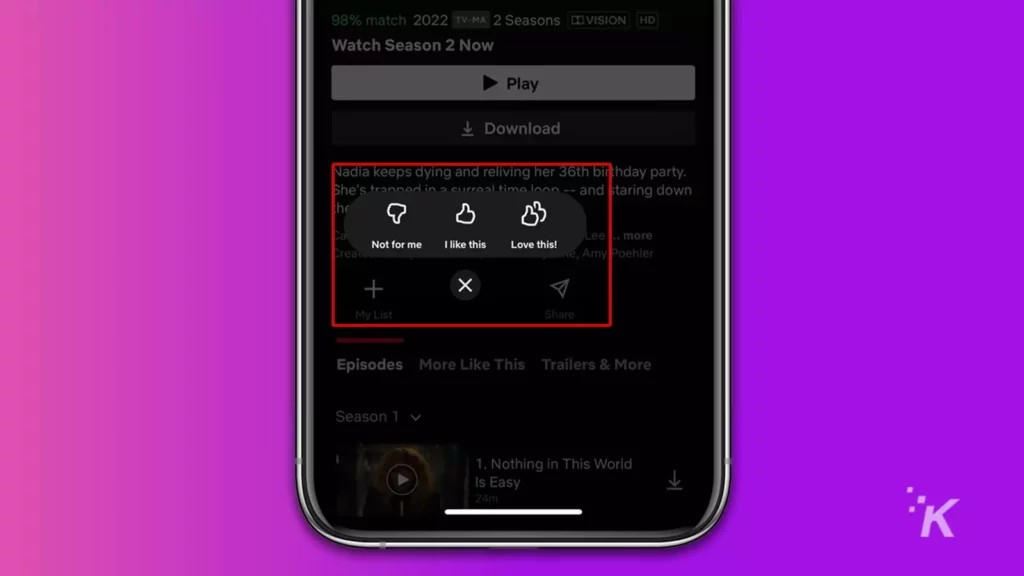

In our improved model - we divided the "liked" movies (those who were rated with a score of 3 and above) into 3 groups, and we handed this data into the model. This way, the movies under the 5-stars category, should have a stronger effect on the next movie the user will watch, than the 3-stars ones. 

The strucutre of the model is as follows:

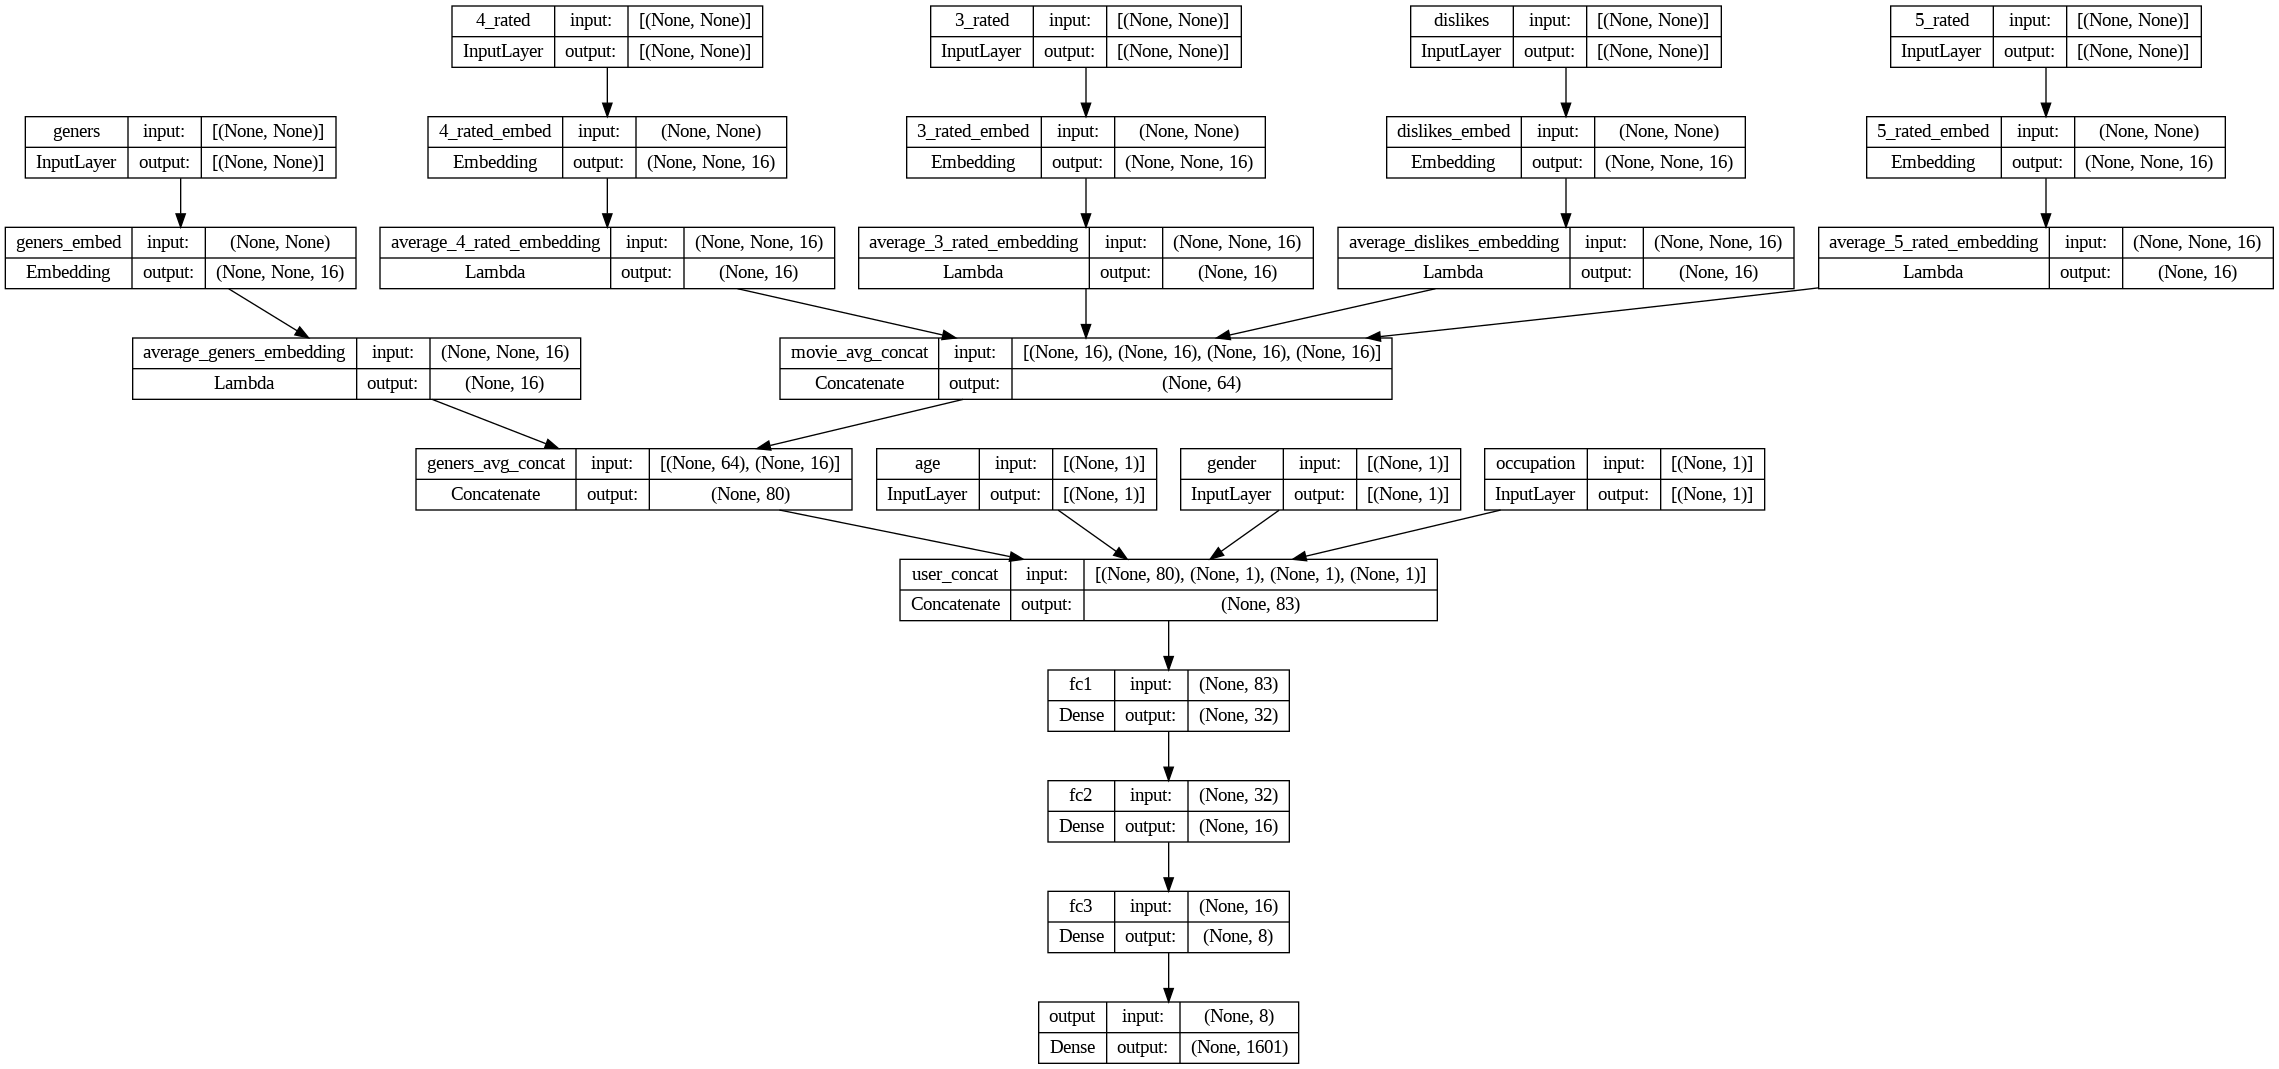

In [68]:
# # Constants
EMBEDDING_DIMS = 64 # number of dimensions in the embeddings, we will need to get this as a hyper-param

def get_improved_model(embedding_dims = 32, learning_rate = 0.01, mode = 'train', no_of_output_layer_options = no_of_output_layer_options,
                       max_rated_ids = [max_rated_5, max_rated_4, max_rated_3], max_id_disliked=max_id_disliked, max_geners=max_geners, dense_sizes=[32, 16, 8]):
    # Define input layers
    user_rated_5_input = Input(shape=(None,), name='5_rated')
    user_rated_4_input = Input(shape=(None,), name='4_rated')
    user_rated_3_input = Input(shape=(None,), name='3_rated')
    movie_disliked_id_input = Input(shape=(None,), name='dislikes')
    geners_input = Input(shape=(None,), name='geners')
    age_input = Input(shape=(1,), name='age')
    gender_input = Input(shape=(1,), name='gender')
    occupation_input = Input(shape=(1,), name='occupation')
    

    # Define embedding layer for movie liked IDs
    user_rated_5_embed = Embedding(input_dim=int(max_rated_ids[0] + 1), output_dim=embedding_dims, trainable=True, name='5_rated_embed')(user_rated_5_input)
    user_rated_4_embed = Embedding(input_dim=int(max_rated_ids[1] + 1), output_dim=embedding_dims, trainable=True, name='4_rated_embed')(user_rated_4_input)
    user_rated_3_embed = Embedding(input_dim=int(max_rated_ids[2] + 1), output_dim=embedding_dims, trainable=True, name='3_rated_embed')(user_rated_3_input)

    # Average the movie ID embeddings
    user_rated_5_avg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), name='average_5_rated_embedding')(user_rated_5_embed)
    user_rated_4_avg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), name='average_4_rated_embedding')(user_rated_4_embed)
    user_rated_3_avg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), name='average_3_rated_embedding')(user_rated_3_embed)

    # Define embedding layer for movie disliked IDs
    movie_disliked_id_embed = Embedding(input_dim=int(max_id_disliked + 1), output_dim=embedding_dims, trainable=True, name='dislikes_embed')(movie_disliked_id_input)

    # Average the movie ID embeddings
    movie_disliked_id_avg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), name='average_dislikes_embedding')(movie_disliked_id_embed)

    # Define embedding layer for geners
    geners_embed = Embedding(input_dim=int(max_geners + 1), output_dim=embedding_dims, trainable=True, name='geners_embed')(geners_input)

    # Average the geners embeddings
    geners_avg = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1), name='average_geners_embedding')(geners_embed)

    # Concatenate the three average embeddings
    # movie_avg_concat = Concatenate(name='movie_avg_concat')([movie_id_avg, movie_name_avg, movie_days_input])
    movie_avg_concat = Concatenate(name='movie_avg_concat')([user_rated_5_avg, user_rated_4_avg, user_rated_3_avg, movie_disliked_id_avg])
    geners_avg_concat = Concatenate(name='geners_avg_concat')([movie_avg_concat, geners_avg])

    # Concatenate all input layers
    user_concat = Concatenate(name='user_concat')([geners_avg_concat, age_input, gender_input, occupation_input])

    # dense layers
    fc1 = Dense(dense_sizes[0], activation='relu', name='fc1', kernel_regularizer=regularizers.l2(0.01) )(user_concat)
    fc2 = Dense(dense_sizes[1], activation='relu', name='fc2', kernel_regularizer=regularizers.l2(0.01))(fc1)
    fc3 = Dense(dense_sizes[2], activation='relu', name='fc3', kernel_regularizer=regularizers.l2(0.01))(fc2)

    # Define output layer with softmax activation
    output = Dense(no_of_output_layer_options + 1, activation='softmax', name='output')(fc3)

    # Define the model
    model = Model(inputs=[user_rated_5_input, user_rated_4_input, user_rated_3_input, movie_disliked_id_input, geners_input, age_input, gender_input, occupation_input], outputs=output)
    model.compile(Adam(learning_rate=learning_rate), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model

improved_model = get_improved_model(embedding_dims = 16, learning_rate = 0.001)
plot_model(improved_model, to_file='get_improved_model.png', show_shapes=True, show_layer_names=True)

In [69]:
from sklearn.model_selection import train_test_split

# assuming your data frame is called "df"
X = results_for_improved.drop(['next_movie_to_watch'], axis=1)  # input features
y = results_for_improved['next_movie_to_watch']  # output label

# split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = X_train.copy()
train_data["next_movie_to_watch"] = y_train.values
test_data = X_test.copy()
test_data["next_movie_to_watch"] = y_test.values
# train_data.head()

In [70]:
def prepare_input_data_for_improved_model(train_df, test_df):
    train_input = [
            tf.keras.preprocessing.sequence.pad_sequences(train_df['movies_rated_5']),
            tf.keras.preprocessing.sequence.pad_sequences(train_df['movies_rated_4']),
            tf.keras.preprocessing.sequence.pad_sequences(train_df['movies_rated_3']),
            tf.keras.preprocessing.sequence.pad_sequences(train_df['dislikes']),
            tf.keras.preprocessing.sequence.pad_sequences(train_df['geners']),
            train_df['age_normalized'],
            train_df['gender'],
            train_df['occupation']
            ]
    train_labels = train_df["next_movie_to_watch"].values

    test_input = [
            tf.keras.preprocessing.sequence.pad_sequences(test_df['movies_rated_5']),
            tf.keras.preprocessing.sequence.pad_sequences(test_df['movies_rated_4']),
            tf.keras.preprocessing.sequence.pad_sequences(test_df['movies_rated_3']),
            tf.keras.preprocessing.sequence.pad_sequences(test_df['dislikes']),
            tf.keras.preprocessing.sequence.pad_sequences(test_df['geners']),
            test_df['age_normalized'],
            test_df['gender'],
            test_df['occupation']
                  ]
    test_labels = test_df["next_movie_to_watch"].values

    return train_input, train_labels, test_input, test_labels

### Traning

In [71]:
def fit_model(train_input, train_labels, model, epochs=3, batch_size=128, model_name="base_model", callbacks=[]):
    # fit the model
    start_time = time()
    history = model.fit(train_input, train_labels, validation_split=0.1, steps_per_epoch=1, epochs=epochs, verbose=1, batch_size=batch_size, callbacks=callbacks)
    train_time = time() - start_time

    return model, history, train_time

epochs = 5
batch_size = 256
train_input, train_labels, test_input, test_labels = prepare_input_data_for_improved_model(train_data, test_data)
improved_model, improved_model_history, improved_train_time = fit_model(train_input, train_labels, model=improved_model, batch_size=batch_size, epochs=epochs) 

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 8.1732 - accuracy: 0.0000e+00 - val_loss: 8.1593 - val_accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 1s 521ms/step - loss: 8.1584 - accuracy: 0.0000e+00 - val_loss: 8.1479 - val_accuracy: 0.0000e+00
Epoch 3/5
1/1 [==============================] - 1s 591ms/step - loss: 8.1337 - accuracy: 0.0000e+00 - val_loss: 8.1367 - val_accuracy: 0.0000e+00
Epoch 4/5
1/1 [==============================] - 1s 540ms/step - loss: 8.1163 - accuracy: 0.0000e+00 - val_loss: 8.1258 - val_accuracy: 0.0000e+00
Epoch 5/5
1/1 [==============================] - 1s 853ms/step - loss: 8.1161 - accuracy: 0.0000e+00 - val_loss: 8.1151 - val_accuracy: 0.0000e+00


### Optimization of hyper-params

In [72]:
# # hyper-params to optimize

# top_k = 100
# epochs = [100, 200, 300]
# batch_sizes = [32, 64, 128]
# latent_dims = [16, 32, 64, 128] #, 256
# learning_rates = [0.01, 0.1] #0.001, 
# fc_layers_sizes = [[512, 256, 128], [256, 128, 64], [128, 64, 32]] #, [64, 32, 16]

# early_stopping = EarlyStopping(patience=3)

# print('The total number of combinations for each model is ', len(learning_rates) * len(batch_sizes)* len(epochs)* len(latent_dims)* len(fc_layers_sizes))

In [73]:
# hyper-params to optimize

top_k = 100
epochs = [5]
batch_sizes = [32, 64]
latent_dims = [16] #, 256
learning_rates = [0.01] #0.001, 
fc_layers_sizes = [[512, 256, 128]] #, [64, 32, 16]

early_stopping = EarlyStopping(patience=3)

print('The total number of combinations for each model is ', len(learning_rates) * len(batch_sizes)* len(epochs)* len(latent_dims)* len(fc_layers_sizes))

The total number of combinations for each model is  2


In [74]:
# loop over hyperparameters
models_names = ['baseline', 'improved'] 

for model_name in models_names:
    csv_path = f'results/{model_name}.csv'
    if os.path.exists(csv_path):
        print(f'Results already exist for {model_name}')
        continue
    for no_epochs in epochs:
        for batch_size in batch_sizes:
            for latent_dim in latent_dims:
                for lr in learning_rates:
                    for fc_layers_size in fc_layers_sizes:
                        # train model with current hyperparameters
                        print(f'Training {model_name} model with no_epochs={no_epochs}, batch_size={batch_size}, latent_dim={latent_dim}, lr={lr}, fc1={fc_layers_size[0]}, fc2={fc_layers_size[1]}, fc3={fc_layers_size[2]}')

                        model = get_improved_model(embedding_dims = latent_dim, learning_rate = lr,  dense_sizes=fc_layers_size) #compile is in the function 

                        model, model_history, train_time = fit_model(train_input, train_labels, model, epochs=no_epochs, batch_size=batch_size, model_name=model_name, callbacks=[early_stopping])
                        test_pred = model.predict(test_input)
                        hr_score = get_hitratio(test_labels, test_pred.argsort(), top_k)


                        # save results to dataframe and files
                        models_hyperparams_comparison = models_hyperparams_comparison.append({
                                                    'model': model_name,
                                                    'epochs': no_epochs,
                                                    'batch_size': batch_size,
                                                    'latent_dims': latent_dim,
                                                    'learning_rates': lr,
                                                    'fc_layers_sizes': fc_layers_size,
                                                    'loss': model_history.history['val_loss'][-1], 
                                                    'accuracy': model_history.history['val_accuracy'][-1],
                                                    'loss_history': model_history.history['val_loss'],
                                                    'hr_score': hr_score},
                                                    ignore_index=True)
                        print(type(model_history.history['val_loss']))

    models_hyperparams_comparison.to_csv(csv_path, index=False)
                        


Results already exist for baseline
Results already exist for improved


### Showing results - Improved model

In [75]:
# models_hyperparams_comparison

# Define a function to convert string representation of list to a list of floats
def str_to_list(s):
    return [float(x) for x in ast.literal_eval(s)]

models_hyperparams_comparison = pd.read_csv('./results/improved.csv', converters={'loss_history': str_to_list})
models_hyperparams_comparison

,model,epochs,batch_size,latent_dims,learning_rates,fc_layers_sizes,loss,accuracy,loss_history,hr_score
0,improved,100,32,16,0.01,"[512, 256, 128]",7.767543,0.000000,"[12.218377113342285, 10.880032539367676, 10.01...",0.047619
1,improved,100,32,16,0.01,"[256, 128, 64]",7.339767,0.013158,"[10.458603858947754, 9.817193031311035, 9.2607...",0.005291
2,improved,100,32,16,0.01,"[128, 64, 32]",7.608030,0.013158,"[9.309892654418945, 8.989874839782715, 8.70744...",0.021164
3,improved,100,32,16,0.10,"[512, 256, 128]",57.311176,0.000000,"[235.4927520751953, 90.82893371582031, 41.3130...",0.074074
4,improved,100,32,16,0.10,"[256, 128, 64]",15.347757,0.013158,"[59.07048034667969, 12.233377456665039, 12.851...",0.058201
...,...,...,...,...,...,...,...,...,...,...
427,baseline,300,128,128,0.01,"[256, 128, 64]",7.916405,0.000000,"[11.641446113586426, 10.490033149719238, 9.539...",0.031746
428,baseline,300,128,128,0.01,"[128, 64, 32]",8.605894,0.013158,"[9.905462265014648, 9.333385467529297, 8.84807...",0.031746
429,baseline,300,128,128,0.10,"[512, 256, 128]",91.460983,0.000000,"[42.82326889038086, 143.8712615966797, 40.2346...",0.021164
430,baseline,300,128,128,0.10,"[256, 128, 64]",18.123167,0.000000,"[14.270641326904297, 18.66716957092285, 17.223...",0.068783


In [76]:
improved_results = models_hyperparams_comparison[models_hyperparams_comparison["model"] == "improved"]
min_loss_indices = models_hyperparams_comparison.groupby('model')['loss'].idxmin()
improved_loss_df = models_hyperparams_comparison.loc[min_loss_indices]
improved_loss_df

,model,epochs,batch_size,latent_dims,learning_rates,fc_layers_sizes,loss,accuracy,loss_history,hr_score
218,baseline,100,32,16,0.01,"[128, 64, 32]",7.240024,0.013158,"[9.125755310058594, 8.862466812133789, 8.61898...",0.015873
74,improved,200,32,16,0.01,"[128, 64, 32]",7.210659,0.013158,"[9.322611808776855, 9.018847465515137, 8.75308...",0.037037


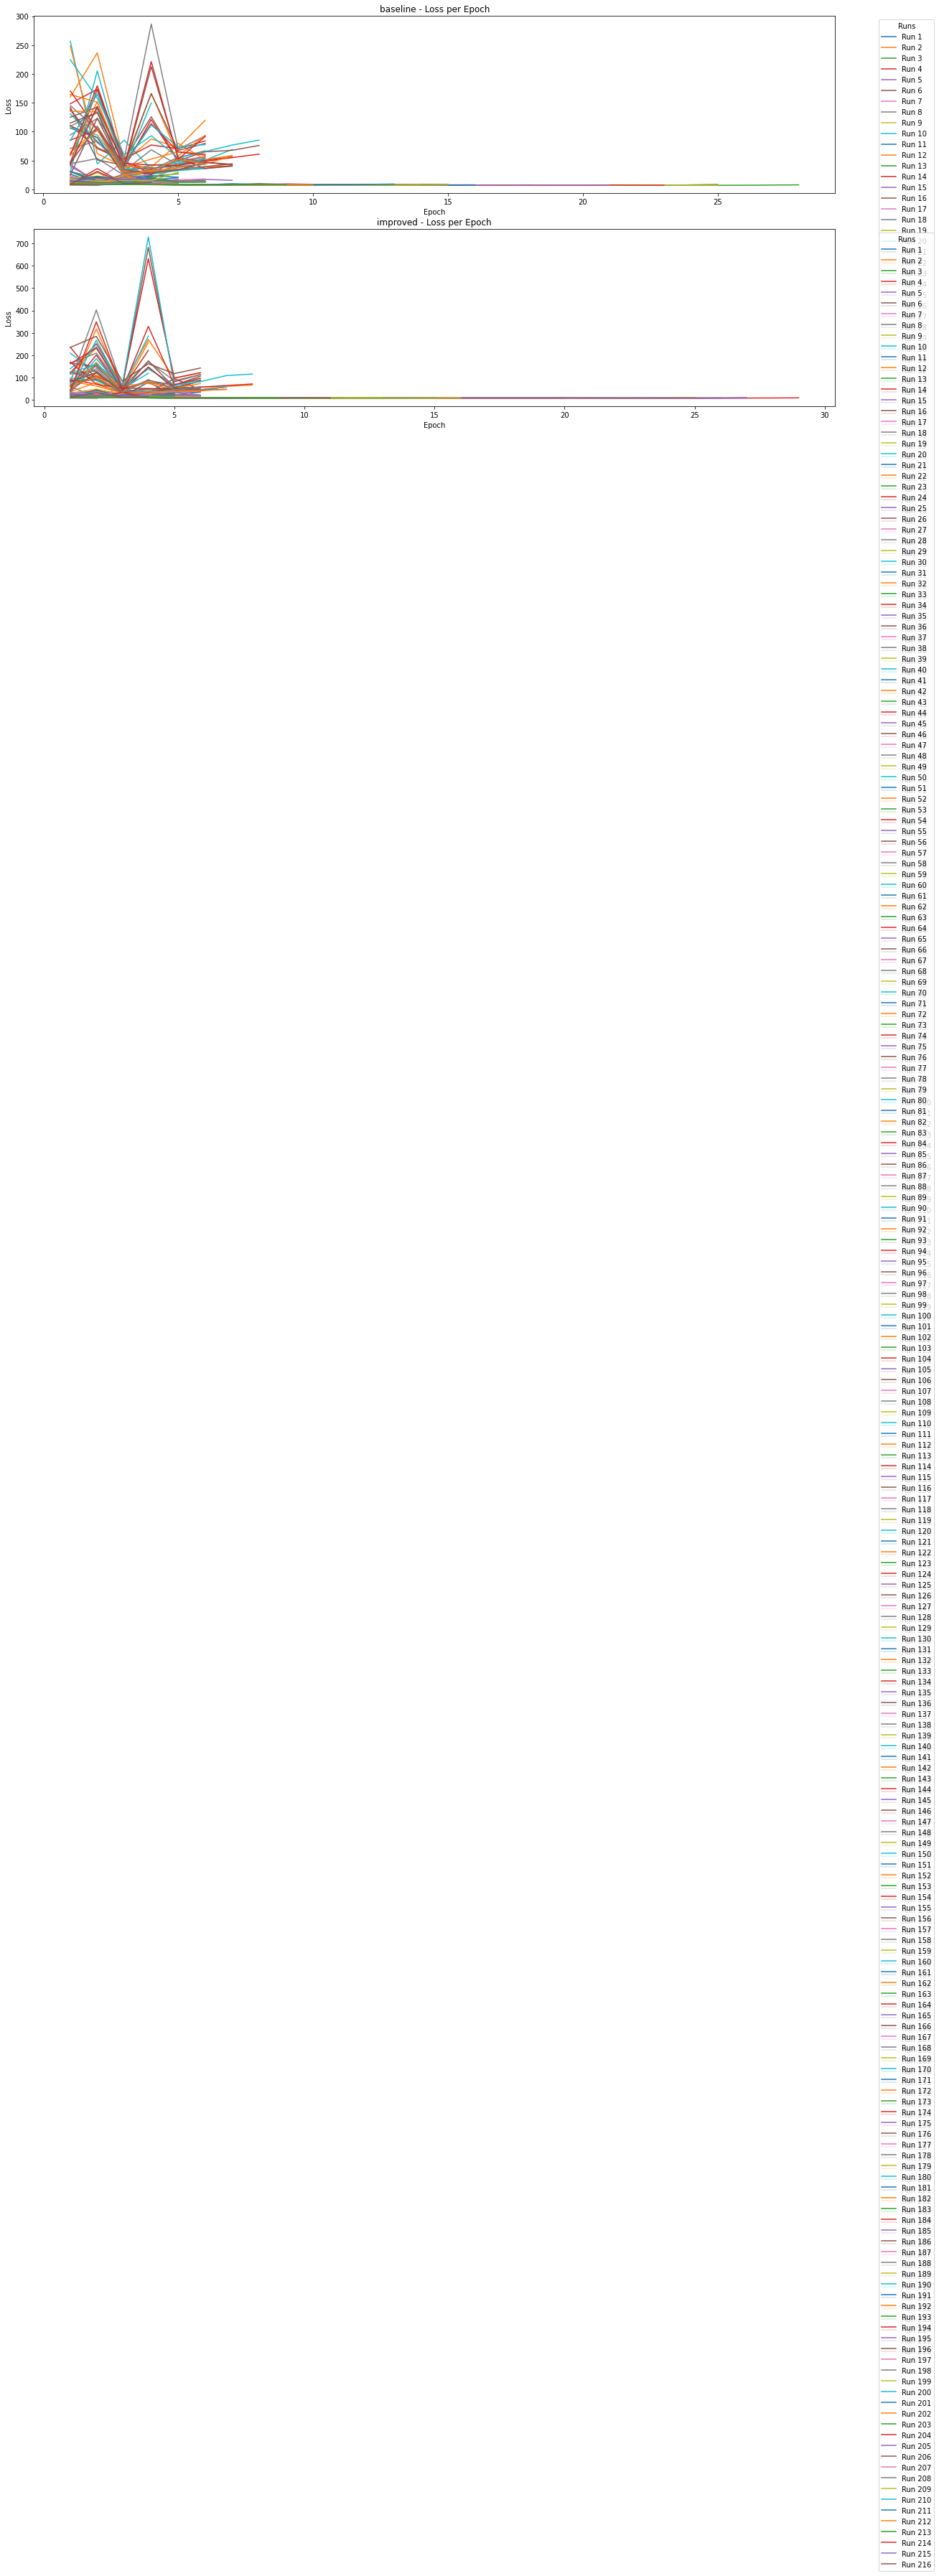

In [77]:
# Create a new figure and axis object
models_names = ["baseline", "improved"]
fig, ax = plt.subplots(len(models_names), 1, figsize=(20, 10))

# Loop over the models
for j, model_name in enumerate(models_names):
    # Select the rows of the DataFrame that correspond to the current model
    model_df = models_hyperparams_comparison[models_hyperparams_comparison['model'] == model_name]
    
    # Get the loss history array for the current model
    loss_histories = model_df['loss_history'].to_numpy()
    
    # Create a list to store the lines for this model
    lines = []
    
    # Loop over the loss histories for the current model and plot the loss per epoch
    for i, loss_history in enumerate(loss_histories):
        line, = ax[j].plot(range(1, len(loss_history)+1), loss_history, label=f"Run {i + 1}")
        # line.set_label(f'Run {i+1}')
        lines.append(line)
        
        # Set the axis labels and title for this subplot
        ax[j].set_xlabel('Epoch')
        ax[j].set_ylabel('Loss')
        ax[j].set_title(f'{model_name} - Loss per Epoch')
    
    # Add a legend for this model
    ax[j].legend(lines, [line.get_label() for line in lines], title='Runs', bbox_to_anchor=(1.05, 1), loc='upper left')
    
# Show the plot
plt.show()

# Comparing to a well-known algorithm - Matrix Factorization

The paper mentiones that the previous model they were using was MF, so we will compare to this one.  

#### Model description and architecture

In [78]:
def RMSE(df_true: pd.DataFrame, df_pred: pd.DataFrame, lower_bound=1, upper_bound=5) -> float:
    """
    Function receives two DataFrames of movies and returns the RMSE. 
    The df_pred consists of the projected values and df_true consists of the real ratings of the users.  
    *The df the function receives only the movies (columns) that were recommended by the system*.

    :param df_true: df consisting the projected values for each given data point 
    :type df_true: df
    :param df_pred: df consisting the real values for each given data point 
    :type df_pred: df
    :return: the RMSE score of the two arrays
    :rtype: float
    """
    # firsly we will replace all values in df_pred with 0, where df_true equals zero (so we will not take them into account in calculating the RMSE score
    df_pred_rmse = df_pred.where(df_true!=0, 0)

    df_true_rmse = df_true.where(df_pred!=0, 0)

    # we will sum all values and then divide by the number of values
    number_of_values = np.count_nonzero(df_pred_rmse)

    # summing all values:
    total_sum_of_squares = (((df_pred_rmse - df_true_rmse) ** 2).sum(axis=1).sum())

    # returning RMSE
    return np.sqrt(total_sum_of_squares / number_of_values)

In [79]:
def mf_hit_ratio(predicted_df, ratings_df, users, k=10):
    hit_ratios = []
    
    for user_id in users:
        # Select the unrated movies for this user
        # unrated_movies = ratings_df.loc[user_id][ratings_df.loc[user_id] == 0].index
        
        # Predict the rating for each unrated movie
        ratings_pred = predicted_df.loc[user_id]
        
        # Select the top k unrated movies with the highest predicted rating
        top_k_movies = ratings_pred.sort_values(ascending=False)[:k]
        
        # Check how many of the top k movies the user has actually rated
        rated_movies = ratings_df.loc[user_id][top_k_movies.index]
        num_hits = np.sum(rated_movies > 0)
        
        # Compute the hit ratio for this user
        hit_ratio = num_hits / k
        hit_ratios.append(hit_ratio)
    
    # Compute the average hit ratio over all users
    avg_hit_ratio = np.mean(hit_ratios)
    
    return avg_hit_ratio

In [80]:
class MF():
    
    def __init__(self, df_train, n_factors=10, only_bias=False):
        self.df_train = df_train
        self.n_factors = n_factors
        self.only_bias = only_bias
        
        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape
        
        # biases
        self.original_bias_global = np.sum(df_train) / np.count_nonzero(df_train)
        self.original_bias_rows = np.sum(df_train,axis=1) / np.count_nonzero(df_train,axis=1) 
        self.original_bias_cols = np.sum(df_train,axis=0) / np.count_nonzero(df_train,axis=0)
        
        # "reset" initialization 
        self.initilize_params()
        
        
    def initilize_params(self):
        if self.only_bias:
            self.weights_user_feature_mat = np.zeros((self.n_rows, self.n_factors))
            self.weights_movie_feature_mat = np.zeros((self.n_cols, self.n_factors))
        else:
            self.weights_user_feature_mat = np.random.uniform(size=(self.n_rows, self.n_factors))
            self.weights_movie_feature_mat = np.random.uniform(size=(self.n_cols, self.n_factors))
        
        # initilize bias
        self.bias_global = self.original_bias_global   # no need to learn it
        self.bias_rows = np.random.uniform(size=(self.n_rows))
        self.bias_cols = np.random.uniform(size=(self.n_cols))
            
        
    def fit(self,
            n_iterations = 1,
            learning_rate = 1e-1,
            regularization = 1e-2,
            convergence = 1e-5,
            error = 'RMSE',
            initilize_training = True,
            verbose = False):
        
        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
                  
        if initilize_training:
            self.initilize_params()

           
        # please record your progress in history
        self.history = []
                  
        # please record the training time in fit_time
        self.fit_time = None
        start_time = time()

        # please use the class functions 
        
        for current_iteration in range(self.n_iterations):

            self.history.append(self.get_rmse(self.df_train))
            
            if verbose:
                print('iteration: ',current_iteration,' total error:\n',self.history[-1])
            
            # convergence
            if current_iteration != 0 and self.converging():
                
                if verbose:
                    print('converged...')
                break
            
            self.rows_indices = np.arange(self.n_rows)
            self.cols_indices = np.arange(self.n_cols)
            self.optim_GD()
        
        end_time = time()
        self.fit_time = end_time - start_time

    
    def converging(self):
        np.abs(self.history[-1] - self.history[-2]) < self.ϵ

                  
    def optim_GD(self):
        # you can use np.dot,np.eye,np.linalg.solve,etc.
        # collect the index row and col for all values in df_train that has rating != 0
        non_zero_idx = [[row, col] for row in range(self.n_rows) for col in range(self.n_cols) if self.df_train[row, col] != 0]
        # iterate over all values in self.df_train
        for rate_val in non_zero_idx:
            pred = np.dot(self.weights_user_feature_mat[rate_val[0]], self.weights_movie_feature_mat[rate_val[1]].T) + self.bias_global + self.bias_rows[rate_val[0]] + self.bias_cols[rate_val[1]]
            error = self.df_train[rate_val[0]][rate_val[1]] - pred
            if not self.only_bias: # update weights
                original_weights_user_feature_mat = self.weights_user_feature_mat[rate_val[0]].copy()
                self.weights_user_feature_mat[rate_val[0]] += self.α * (error * self.weights_movie_feature_mat[rate_val[1]] - self.λ * self.weights_user_feature_mat[rate_val[0]])
                self.weights_movie_feature_mat[rate_val[1]] += self.α * (error * original_weights_user_feature_mat - self.λ * self.weights_movie_feature_mat[rate_val[1]])
            # update bias
            self.bias_rows[rate_val[0]] += self.α * (error * self.bias_rows[rate_val[0]])
            self.bias_cols[rate_val[1]] += self.α * (error * self.bias_cols[rate_val[1]])       
    
        
    def predict(self, N=10):
        return np.dot(self.weights_user_feature_mat, self.weights_movie_feature_mat.T) + self.bias_global + self.bias_rows[:,np.newaxis] + self.bias_cols[np.newaxis,:]    

    def get_rmse(self, test):
        # please use my_metrics
        pred = self.predict()
        return RMSE(pd.DataFrame(test), pd.DataFrame(pred))


### MF train

In [81]:
model_mf = MF(train.values,n_factors=5)
model_mf.fit(n_iterations=5,learning_rate=0.01,regularization=0.1,convergence=0.001)

## MF Optimization

In [82]:
# hyper-params to optimize

top_k = 100
epochs = [100, 200, 300]
latent_dims = [16, 32, 64, 128] #, 256
learning_rates = [0.01, 0.1] #0.001, 

early_stopping = EarlyStopping(patience=3)

print('The total number of combinations for each model is ', len(learning_rates) * len(batch_sizes)* len(epochs)* len(latent_dims)* len(fc_layers_sizes))

The total number of combinations for each model is  48


In [83]:
# # hyper-params to optimize

# top_k = 100
# epochs = [5]
# batch_sizes = [32, 64]
# latent_dims = [16] #, 256
# learning_rates = [0.01] #0.001, 
# fc_layers_sizes = [[512, 256, 128]] #, [64, 32, 16]

# early_stopping = EarlyStopping(patience=3)

# print('The total number of combinations for each model is ', len(learning_rates) * len(batch_sizes)* len(epochs)* len(latent_dims)* len(fc_layers_sizes))

In [84]:
# loop over hyperparameters
models_names = ["baseline", "improved", "MF"]

for model_name in models_names:
    csv_path = f'results/{model_name}.csv'
    # check if results already exist for these hyperparameters
    if os.path.exists(csv_path):
        print(f'Results already exist for {model_name}')
        continue
    for no_epochs in epochs:
        for latent_dim in latent_dims:
            for lr in learning_rates:
                # train model with current hyperparameters
                print(f'Training {model_name} model with no_epochs={no_epochs}, latent_dim={latent_dim}, lr={lr}')

                model_mf = MF(train.values,n_factors=latent_dim)
                model_mf.fit(n_iterations=no_epochs, learning_rate=lr, regularization=0.1, convergence=0.001)
                model_history = model_mf.history
                model_loss = model_mf.history[-1]
                
                mf_ratings_pred = model_mf.predict(test)
                mf_ratings_pred_df = pd.DataFrame(mf_ratings_pred, index=range(1, len(mf_ratings_pred)+1), columns = range(1, mf_ratings_pred.shape[1]+1))

                hr_score = mf_hit_ratio(predicted_df=mf_ratings_pred_df, ratings_df=test, users=list(range(1, mf_ratings_pred_df.shape[0]+1)), k=top_k)


                # save results to dataframe and files
                models_hyperparams_comparison = models_hyperparams_comparison.append({
                                            'model': model_name,
                                            'epochs': no_epochs,
                                            'batch_size': None,
                                            'latent_dims': latent_dim,
                                            'learning_rates': lr,
                                            'fc_layers_sizes': None,
                                            'loss': model_loss, 
                                            'accuracy': None,
                                            'loss_history': model_history,
                                            'hr_score': hr_score},
                                            ignore_index=True)

    models_hyperparams_comparison.to_csv(csv_path, index=False)

Results already exist for baseline
Results already exist for improved
Results already exist for MF


In [85]:
# # models_hyperparams_comparison
# import ast

# Define a function to convert string representation of list to a list of floats
def str_to_list(s):
    return [float(x) for x in ast.literal_eval(s)]

models_hyperparams_comparison = pd.read_csv('./results/MF.csv')

new_loss_history = []
for loss_arr in models_hyperparams_comparison["loss_history"].values:
    loss_history_per_model = []
    vals_to_conv = (loss_arr.split("[")[1].split("]")[0])
    for val in vals_to_conv.split(", "):
        loss_history_per_model.append(float(val))
    new_loss_history.append(loss_history_per_model)


# models_hyperparams_comparison[models_hyperparams_comparison["model"] == "MF"].loc[:, "loss_history"] = new_loss_history
models_hyperparams_comparison["loss_history"] = new_loss_history
models_hyperparams_comparison

# for i, val in enumerate(models_hyperparams_comparison["loss_history"].values):
#     print(list(models_hyperparams_comparison["loss_history"].iloc[i]))
#     # print(type(val))
#     break
# models_hyperparams_comparison

,model,epochs,batch_size,latent_dims,learning_rates,fc_layers_sizes,loss,accuracy,loss_history,hr_score
0,MF,50,NaN,16,0.01,NaN,0.760413,NaN,"[5.165001642785781, 1.1710843865794207, 1.0670...",0.019364
1,MF,50,NaN,16,0.10,NaN,0.764437,NaN,"[5.277637499058402, 1.0422257355810438, 0.9090...",0.016734
2,MF,50,NaN,32,0.01,NaN,0.708749,NaN,"[9.199254397387215, 1.1802266557177612, 1.0430...",0.020308
3,MF,50,NaN,32,0.10,NaN,0.000000,NaN,"[9.114623650203523, 1.0174563368282465, 0.0181...",0.032142
4,MF,50,NaN,64,0.01,NaN,0.666613,NaN,"[17.1847884773039, 1.1877908427795765, 0.99877...",0.020976
...,...,...,...,...,...,...,...,...,...,...
443,baseline,300,128.0,128,0.01,"[256, 128, 64]",7.916405,0.000000,"[11.641446113586426, 10.490033149719238, 9.539...",0.031746
444,baseline,300,128.0,128,0.01,"[128, 64, 32]",8.605894,0.013158,"[9.905462265014648, 9.333385467529297, 8.84807...",0.031746
445,baseline,300,128.0,128,0.10,"[512, 256, 128]",91.460983,0.000000,"[42.82326889038086, 143.8712615966797, 40.2346...",0.021164
446,baseline,300,128.0,128,0.10,"[256, 128, 64]",18.123167,0.000000,"[14.270641326904297, 18.66716957092285, 17.223...",0.068783


In [86]:
mf_results = models_hyperparams_comparison[models_hyperparams_comparison["model"] == "MF"]
min_loss_indices = mf_results.groupby('model')['loss'].idxmin()
mf_loss_df = mf_results.loc[min_loss_indices]
mf_loss_df

,model,epochs,batch_size,latent_dims,learning_rates,fc_layers_sizes,loss,accuracy,loss_history,hr_score
3,MF,50,NaN,32,0.1,NaN,0.0,NaN,"[9.114623650203523, 1.0174563368282465, 0.0181...",0.032142


## Showing results 

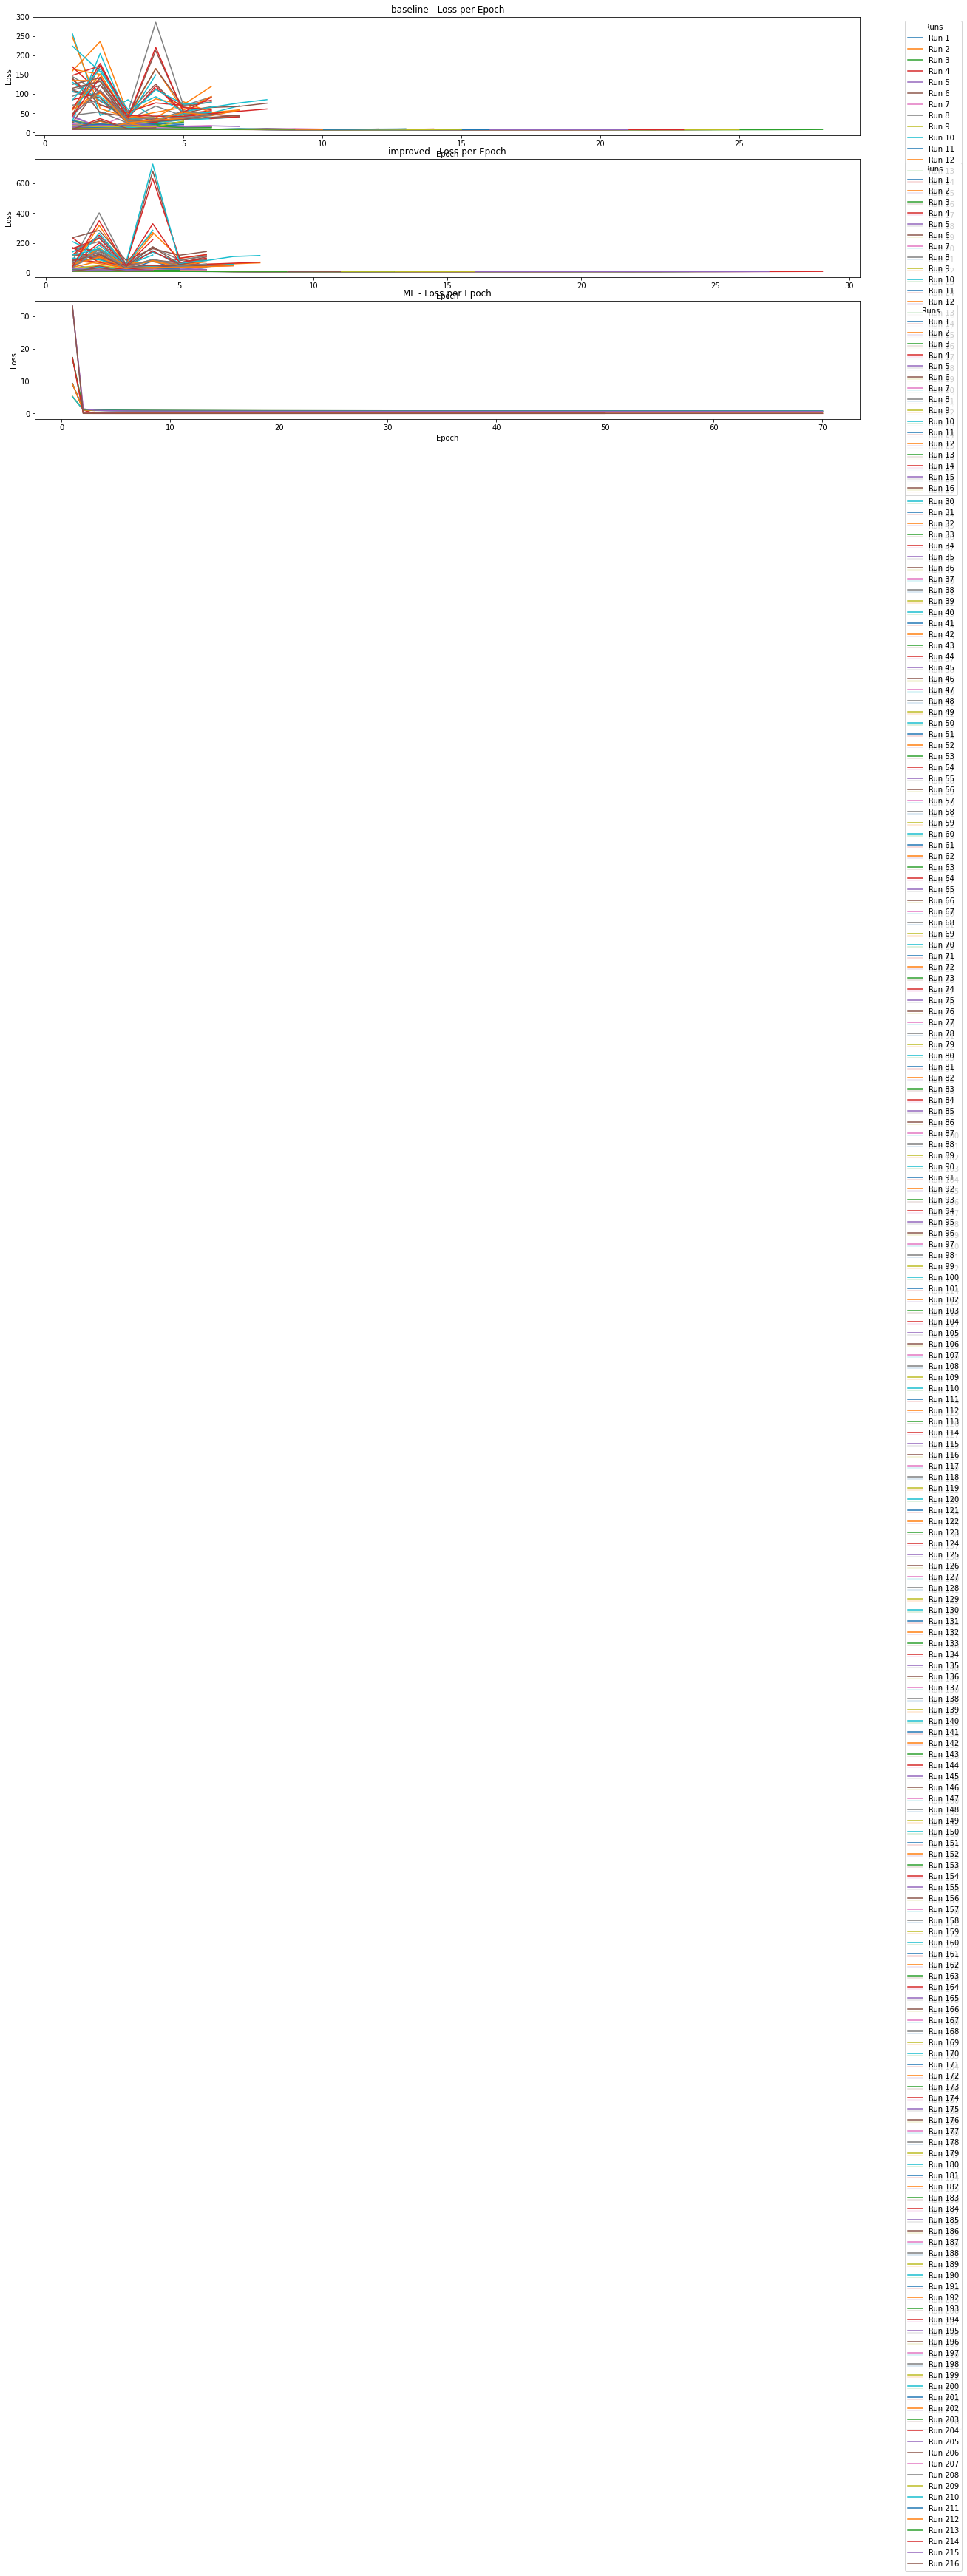

In [88]:
# Create a new figure and axis object
models_names = ["baseline", "improved", "MF"]
fig, ax = plt.subplots(len(models_names), 1, figsize=(20, 10))

# Loop over the models
for j, model_name in enumerate(models_names):
    # Select the rows of the DataFrame that correspond to the current model
    model_df = models_hyperparams_comparison[models_hyperparams_comparison['model'] == model_name]
    
    # Get the loss history array for the current model
    loss_histories = model_df['loss_history'].to_numpy()
    
    # Create a list to store the lines for this model
    lines = []
    # break
    
    # Loop over the loss histories for the current model and plot the loss per epoch
    for i, loss_history in enumerate(loss_histories):
        line, = ax[j].plot(range(1, len(loss_history)+1), loss_history, label=f"Run {i + 1}")
        # line.set_label(f'Run {i+1}')
        lines.append(line)
        
        # Set the axis labels and title for this subplot
        ax[j].set_xlabel('Epoch')
        ax[j].set_ylabel('Loss')
        ax[j].set_title(f'{model_name} - Loss per Epoch')
    
    # Add a legend for this model
    ax[j].legend(lines, [line.get_label() for line in lines], title='Runs', bbox_to_anchor=(1.05, 1), loc='upper left')
    
# Show the plot
plt.show()

# Comparing results between the different models



In [89]:
models_hyperparams_comparison

,model,epochs,batch_size,latent_dims,learning_rates,fc_layers_sizes,loss,accuracy,loss_history,hr_score
0,MF,50,NaN,16,0.01,NaN,0.760413,NaN,"[5.165001642785781, 1.1710843865794207, 1.0670...",0.019364
1,MF,50,NaN,16,0.10,NaN,0.764437,NaN,"[5.277637499058402, 1.0422257355810438, 0.9090...",0.016734
2,MF,50,NaN,32,0.01,NaN,0.708749,NaN,"[9.199254397387215, 1.1802266557177612, 1.0430...",0.020308
3,MF,50,NaN,32,0.10,NaN,0.000000,NaN,"[9.114623650203523, 1.0174563368282465, 0.0181...",0.032142
4,MF,50,NaN,64,0.01,NaN,0.666613,NaN,"[17.1847884773039, 1.1877908427795765, 0.99877...",0.020976
...,...,...,...,...,...,...,...,...,...,...
443,baseline,300,128.0,128,0.01,"[256, 128, 64]",7.916405,0.000000,"[11.641446113586426, 10.490033149719238, 9.539...",0.031746
444,baseline,300,128.0,128,0.01,"[128, 64, 32]",8.605894,0.013158,"[9.905462265014648, 9.333385467529297, 8.84807...",0.031746
445,baseline,300,128.0,128,0.10,"[512, 256, 128]",91.460983,0.000000,"[42.82326889038086, 143.8712615966797, 40.2346...",0.021164
446,baseline,300,128.0,128,0.10,"[256, 128, 64]",18.123167,0.000000,"[14.270641326904297, 18.66716957092285, 17.223...",0.068783


In [90]:
best_res = pd.DataFrame()

for model_name in models_names:
    mf_results = models_hyperparams_comparison[models_hyperparams_comparison["model"] == model_name]
    min_loss_indices = mf_results.groupby('model')['loss'].idxmin()
    loss_df = mf_results.loc[min_loss_indices]
    best_res = best_res.append(loss_df).reset_index(drop=True)

best_res

,model,epochs,batch_size,latent_dims,learning_rates,fc_layers_sizes,loss,accuracy,loss_history,hr_score
0,baseline,100,32.0,16,0.01,"[128, 64, 32]",7.240024,0.013158,"[9.125755310058594, 8.862466812133789, 8.61898...",0.015873
1,improved,200,32.0,16,0.01,"[128, 64, 32]",7.210659,0.013158,"[9.322611808776855, 9.018847465515137, 8.75308...",0.037037
2,MF,50,NaN,32,0.10,NaN,0.000000,NaN,"[9.114623650203523, 1.0174563368282465, 0.0181...",0.032142


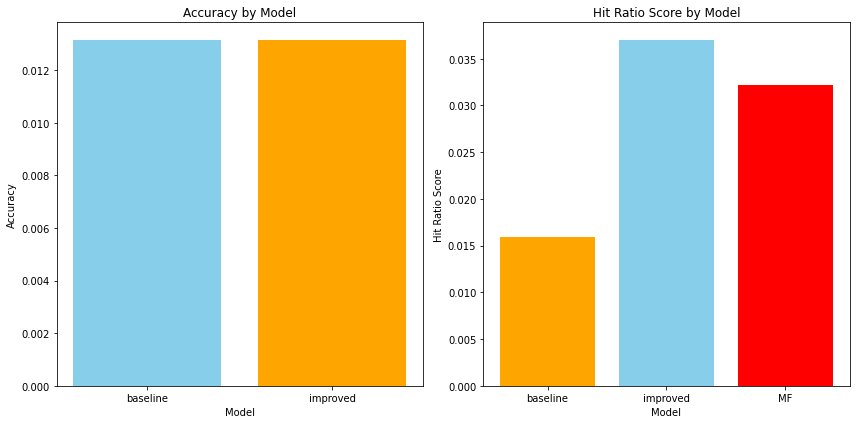

In [91]:
plt.figure(figsize=(12, 6))


x = best_res['model']


accuracy = best_res['accuracy']
hr_score = best_res['hr_score']
accuracy_colors = ['skyblue', 'orange', 'green', 'red', 'purple']
hr_score_colors = ['orange', 'skyblue', 'red', 'green', 'purple']

# Create the bar chart for accuracy
plt.subplot(1, 2, 1)
plt.bar(x, accuracy, color=accuracy_colors)
plt.title('Accuracy by Model')
plt.xlabel('Model')
plt.ylabel('Accuracy')

# Create the bar chart for hr_score
plt.subplot(1, 2, 2)
plt.bar(x, hr_score, color=hr_score_colors)
plt.title('Hit Ratio Score by Model')
plt.xlabel('Model')
plt.ylabel('Hit Ratio Score')



plt.tight_layout()
plt.show()


# Conclusions

**Building the dataset**
* The data pre-processing part was demanding and required a massive amount of time to prepare and make the data ready for the model. 

* Firstly, while building the dataset for the model, we had to use all of the available data from all of the 3 datasets we had, and combine them together to suit our anchor model. That required a lot of merging data from one table to another. This was made to by complied with the data structure described in the paper. 

* After joining the data together, we had to make adjustments to the data so it can be served into the model. "Categorial data" such as genres and occupations, had to be "categorized" into numbers so the could be served to the model. "COntinuous data", such as age, movie age, time since watching, and more, had to be normalized and than manipulated (squared and rooted) to be served to the model. 

* In the end, we had to use Keras's padding funciton to make all the data the same size for the model - because some users had more rated movies than the others. 
<br>

**Model architecture**
* The model architecture described in the paper included 2 NNs - Can Gen network and a Ranking method. As suggested in class, we combined those two networks and feeded the model with all of the data from the beginning. The structure of the two networks is pretty similar, except for the loss function in the end and a few additional features given to the Ranking NN. 

* Due to the lack of time, we couldn't add the squared and rooted normalized continuous features. 

* Our suggested improvement included even a more complex strucutre - that in real world could be too complex. Nevertheless, we beleive that it can increase the accuracy of the rec sys of YouTube.
<br>

**Measuring the results**
* In contrast to the paper, we missed a few crucial features to enter the model, and also our measuring techniques are different. We couldn't use A/B testing as the paper suggested, and thus we used HitRatio and Accuracy as they suggested. (the paper uses also precision and recall). 

*   We can see that we didn't get high accuracy in the original model and the improved one - that is apparntly due to few reasons. 

*   The first reason could that the model is just too complicated for this small dataset. We used a lot of features but the dataset is pretty small to provide different samples.  

* The second reason the results are not that impressive is probably because the IDs of the movies don't really represent anything "informative", and they are pretty random. In other words, there is no real correlation between the ID of the movie and the next movie to watch (i.e., as high the movie' ID is, the more "likeable" the movie is). If we compare that to a linear regression problem in which we try to predict the price of a house based on its size, number of bedrooms, and number of bathrooms, we can assume that as the number of each of those increase, so do the price of the house. Nevertheless, in this case, since we trying to predict the next movie - we see that this information is not helping.

* To solve this problem, we wanted to use the movie name as the "search history" of the user, but since the model understands the movie name as a whole (meaning that "Batman 1" and "Batman 2" are completeley different movies, and each of them will get a different embedded number, then there was no point in entering them to the data, as we will get the exact same thing as the movie ID. 

* Another solution we had in mind was to use NLP models such as Word2Vec - to actually understand the meaning of similar words, and by thus increase the accuracy of the model. By that, "Batman 1" and "Batman 2" will be "similar" to each other, and a user that liked "Batman 1", will have higher probabilities of being recommended "Batman 2". In addiiton, movies with names that include similar words (such as "lughing something" will probably be a funny movie). 

* We can see that our solution helped in incresing Hit Ratio of the model. 

<bR> 

**Hyper-parameters optimization**
* We can see that the numbers didn't do much to the loss, and the losses convereged more or less to the same areas. We set the early stopping of the model to stop when the val_loss is not improving more than 3 times in a row. We noticed that a lot of the training processes stopped very early - that is probably due to overfitting of the model. This could derive from a few causes -

1. Overfitting - can occur when the model is too complex and starts to fit the noise in the data instead of the underlying patterns. As a result, the model performs well on the training data but poorly on the validation data. Overfitting can lead to an increase in validation loss as the model becomes more complex.

2. Learning rate - the learning rate determines the size of the steps taken during training. If the learning rate is too high, the model may overshoot the optimal solution and start diverging, leading to an increase in validation loss. Nevertheless, we tried using a variety of recommended learning rates, but that also didn't solve the problem. 

3. Dataset size - as mentioned, we think that this is the main reason for the early stopping. 

In summary, we think that the model architecture is just not suitable for the problem we had, using this dataset. 


# Suggestions for future projects
For future projects it would be best to search for a database more similar to the one of youtube both in terms of size, but also in terms of videos' features such as the video's creator, the length, the language, the video quality (which can determine the production quality of the video), whether includes advertisemnts or not, and many many more. In addition, it would be better if we also had more information about the user, rahter than its gender and profession, that YouTube does have, such as language, content generated by that specific user, subscription history (e.g. whether is subscribed to a specifc channel), and more. In addition, since YouTube constitutes somekind of a Social Media network, we can also have the user's comment history as a factor to put into our ML model. 